In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import statistics


#Following packages are needed
import folium
from folium.features import DivIcon
%matplotlib inline
import pandas as pd
import re
import os
import branca.colormap as cm
import re
import math

import geopy.distance
from ipynb.fs.full.Angle import py_ang
from ipynb.fs.full.race_timestamps import start_and_end_of_start
from os.path import exists as file_exists

pd.set_option("max_rows", None)
pd.set_option("max_columns", None)

In [2]:
df = pd.read_csv('df.csv')
df=df.loc[~df['TRK_RACE_NUM_unk'].isnull()]
df['DATETIME']=pd.to_datetime(df['DATETIME'])
df['date_column'] = pd.to_datetime(df['DATETIME']).dt.date
#Dont want to look at final races
df = df.loc[df['extra']!=6.0]
#In cph race 4 was the final race
df = df.loc[df['TRK_RACE_NUM_unk']!=22082004.0]

df = df.loc[df['TRK_RACE_NUM_unk']!= 22111307.0]

# Table of content
> * **0. Introduction**
    >> * 0.1 Problem definition
> * **1. Loading and preparing XML files (race course)**
> * **2. Meters won at gate marks**
    >> * 2.1 Meeters gain by taking left turn at LW gate (LW1 gate mark)
>> * 2.2 Meeters gain by taking left turn at top gate (WW gate) 
>> * 2.3 Subconclusion
> * **3 Detecting TWD**
>> * 3.1 TWD vs TWD_TM_deg
>> * 3.2 Calculating True TWD
>>> * 3.2.1 One boat at a time
>> * 3.3 Create a column with median_TWD_leg
>>> * 3.3.1 Now merging the df_median_TWD and df_merged
> * **4 Defining what mark the boat takes**
>> * 4.1 Subconclusion
> * **5 Dividing the gate in LW_gate and WW_gate and calc boats won**
>> * 5.2 Subconclusion 
> * **6 How much bias is needed?**
>> * 6.1SubConclusion
> * **7 ANOVA test**
    >>* t-test
> * **8 Splitting with the fleet**
>> * 8.1 Subcnclussion 


# 0. Introduction

>This report is built on behalf of the work that is performed in the special course "Conducting a real-life data analytics project". The special course is created for the student Katja Salskov-Iversen, also the author of this report, by professor Kathrin Kirchner. I, Katja, am a Master's student at DTU and a sailor on the Denmark SailGP team.  
>
>The project aims to analyze a real-life case where the problem has to be identified using domain knowledge and answers have to be found using the available qualitative and quantitative data. 
>
>On the Danish Sailing team, we have identified that gate roundings can be very important and defining for the race result and an area that we as sailors can learn much more from by analyzing the data. Hence gate roundings are the focus of this project. 
>
>This report is a summary of the main definitions and findings performed in this special course, and the recipient is the Danish SailGP team. The report aims to increase the reader's knowledge of gate roundings and their importance and thereby help increase the likelihood of better performance in a race. It is assumed that the reader has basic knowledge of sailing.

## 0.1 Problem definition  
>Analyze the gate roundings in SailGP season 3 and its consequences for a boat’s results.
>
>• Gather, clean, and prepare quantitative data from SailGP season 3 including CSV files from the F50s and XML files defining the race course.
>
>• Calculate new, important variables such as distances to marks, the boat’s gate mar kchoice, and relative wind angles.
>
>• Define the "True Wind Direction" and asses the importance of this.
>
>• Analyze the importance of gate bias.
>
>• Analyze a split with the fleet in a gate.
>

# 1. Loading and preparing XML files (race course)

In [3]:
# Name of all xml files 'bermuda_22051401','bermuda_22051402','bermuda_22051403','bermuda_22051504','bermuda_22051505',
filess = ('chicago_22061801','chicago_22061802','chicago_22061803','chicago_22061904','chicago_22061905',
         'plymouth_22073001','plymouth_22073002','plymouth_22073003','plymouth_22073104','plymouth_22073105',
          'plymouth_22073106','cph_22082001','cph_22082002','cph_22082003',
          'stTropez_22091001','stTropez_22091002','stTropez_22091003','stTropez_22091104','stTropez_22091105','stTropez_22091106',
          'cadiz_22092401','cadiz_22092402','cadiz_22092403','cadiz_22092504','cadiz_22092505',
          'dubai_22111201','dubai_22111202','dubai_22111203','dubai_22111304','dubai_22111305','dubai_22111306')

>The coordinates of the gatemarks are defined in the function. First a xml file is loaded, then the specific marks are found and put into a dataframe named  <i>course</i>.
>
> Further, the gate line is defined by a vector. This is done by simple vector calculations where you define a vector between two points. 


LG1-LG2→ = (LG2_long - LG1_long, LG2_lat -LG1_lat ) 

>
> Another vector that needs to be defined is the vector between WG1 and WG2. 
>
> Lastly a dataframe is created with all the coordinates 

In [4]:

#Loafing xml files and creating a list of their parse
def load_xml_files(races):
    """ This functions loads the xml files
    from the different locations 
    and 
    Input: date of race and .xml file
    -------------------------------
    Output: dataframe with coordinate 
    positions of course marks 
    """
    
    all_courses = pd.DataFrame()
    LW_gate_vectors_first = []
    LW_gate_vectors_second = []
    WW_gate_vectors_first = []
    WW_gate_vectors_second = []
    
    LG1_lat = []
    LG1_long = []
    LG2_lat =[]
    LG2_long = []
    WG1_lat = []
    WG1_long = []
    WG2_lat =[]
    WG2_long = []
    
    dato = []

    
##----Loading the races-----
    for race in races:
        xml_file = "xml_files/{}.xml".format(race)
        if (file_exists(xml_file) == False): #Checking if file excist
            print(race, 'does not excist')
        if file_exists(xml_file): #Checking if file excist
            tree = ET.parse('xml_files/{}.xml'.format(race))
            root = tree.getroot()
            
            
    ##-------List all attributes of the mark element in the tree:----
            marks = []
            lat = []
            long = []

            for mark in root.iter('Mark'):
                m = mark.attrib
    ##-----------for all marks take the name, lat and long values------
                for key,value in m.items():
                    if key == 'Name':
                        marks.append(value)
                    if key == 'TargetLat':
                        lat.append(value)
                    if key == 'TargetLng':
                        long.append(value)

    ## -------Create a dataframe with the marks and its coordinates----
    ##--------OBS make sure that there are no dublicates of marks ([0:7])----
            course = pd.DataFrame(
                {'Marks': marks,
                 'Longtitude': long,
                 'Latitude': lat,
                 'Destination': race
                })[0:7]
#             print(course)
            course['Longtitude']= course['Longtitude'].astype(float)
            course['Latitude']= course['Latitude'].astype(float)
            course=course.set_index('Marks')
            all_courses =all_courses.append(course,ignore_index=True)

            
            
    ##--------Calculating LW gate vector -----------
            LWG_vector = ([course['Longtitude'].loc[['LG2']].item() - course['Longtitude'].loc[['LG1']].item(), course['Latitude'].loc[['LG2']].item() - course['Latitude'].loc[['LG1']].item()]) 
## ----------Calculate WW gate vector-------------------------
            WWG_vector = ([course['Longtitude'].loc[['WG2']].item() - course['Longtitude'].loc[['WG1']].item(), course['Latitude'].loc[['WG2']].item() - course['Latitude'].loc[['WG1']].item()]) 

#             Sl1M1_vector = ([course['Longtitude'].loc[['M1']].item() - course['Longtitude'].loc[['SL1']].item(), course['Latitude'].loc[['M1']].item() - course['Latitude'].loc[['SL1']].item()]) 
    ##--------Multiply wioth 1000 to make it visable on the map later-----
            LWG_vector=np.array(LWG_vector)*9000
            LWG_vector=list(LWG_vector)
            WWG_vector=np.array(WWG_vector)*4000
            WWG_vector=list(WWG_vector)
            dato.append(race)
            LW_gate_vectors_first.append(LWG_vector[0])
            LW_gate_vectors_second.append(LWG_vector[1])
            WW_gate_vectors_first.append(WWG_vector[0])
            WW_gate_vectors_second.append(WWG_vector[1])



    ##--------Making lists with the coordinates of the marks-----------
            LG1_long.append(course.loc['LG1']['Longtitude'])
            LG1_lat.append(course.loc['LG1']['Latitude'])
            LG2_long.append(course.loc['LG2']['Longtitude'])
            LG2_lat.append(course.loc['LG2']['Latitude'])
            WG1_long.append(course.loc['WG1']['Longtitude'])
            WG1_lat.append(course.loc['WG1']['Latitude'])
            WG2_long.append(course.loc['WG2']['Longtitude'])
            WG2_lat.append(course.loc['WG2']['Latitude'])



##----Creating a dataframe of the coordinates of the marks---------
    coordinates = pd.DataFrame(np.column_stack([dato,WW_gate_vectors_first, WW_gate_vectors_second,LW_gate_vectors_first, LW_gate_vectors_second,WG1_long,WG1_lat,WG2_long,WG2_lat,LG1_long,LG1_lat,LG2_long,LG2_lat]),columns=['date_column','WW_gate_vectors_first','WW_gate_vectors_second','LW_gate_vectors_first','LW_gate_vectors_second','WG1_long','WG1_lat','WG2_long','WG2_lat','LG1_long','LG1_lat','LG2_long','LG2_lat'])
    coordinates[['Place','TRK_RACE_NUM_unk']]=coordinates['date_column'].str.split('_',1,expand =True)


    return(coordinates)
        

In [5]:
coordinates=load_xml_files(filess)

In [6]:
# Changing all columns except datetime column to float values
coordinates['TRK_RACE_NUM_unk']=coordinates['TRK_RACE_NUM_unk'].astype('float64')
coordinates['LW_gate_vectors_first'] = coordinates['LW_gate_vectors_first'].astype(float)
coordinates['LW_gate_vectors_second'] = coordinates['LW_gate_vectors_second'].astype(float)
coordinates['WW_gate_vectors_first'] = coordinates['WW_gate_vectors_first'].astype(float)
coordinates['WW_gate_vectors_second'] = coordinates['WW_gate_vectors_second'].astype(float)
coordinates['LG1_long'] = coordinates['LG1_long'].astype(float)
coordinates['LG1_lat'] = coordinates['LG1_lat'].astype(float)
coordinates['LG2_long'] = coordinates['LG2_long'].astype(float)
coordinates['LG2_lat'] = coordinates['LG2_lat'].astype(float)
coordinates['WG1_long'] = coordinates['WG1_long'].astype(float)
coordinates['WG1_lat'] = coordinates['WG1_lat'].astype(float)
coordinates['WG2_long'] = coordinates['WG2_long'].astype(float)
coordinates['WG2_lat'] = coordinates['WG2_lat'].astype(float)
# coordinates['date_column'] = pd.to_datetime(coordinates['date_column'])
# df['date_column'] = pd.to_datetime(df['date_column'])

In [7]:
def calc_distance_btw_gatemarks(data):
    dist_betwen_LW_marks = []
    dist_betwen_WW_marks = []
    for row in range(len(data)):
##--------Calculate the distance between the gate marks-----##
        dist_betwen_LW_marks.append(round(geopy.distance.distance([data['LG1_long'][row],data['LG1_lat'][row]],[data['LG2_long'][row],data['LG2_lat'][row]]).m,1))
        dist_betwen_WW_marks.append(round(geopy.distance.distance([data['WG1_long'][row],data['WG1_lat'][row]],[data['WG2_long'][row],data['WG2_lat'][row]]).m,1))
    data['dist_betwen_LW_marks'] =  dist_betwen_LW_marks
    data['dist_betwen_WW_marks'] =  dist_betwen_WW_marks
    
    return(data)

In [8]:
coordinates=calc_distance_btw_gatemarks(coordinates)

In [9]:
#Now merging coordinates and df 
df_merged = pd.merge(df,coordinates, on='TRK_RACE_NUM_unk', how='left')
df_merged.drop('date_column_y',inplace = True, axis=1)
df_merged.rename(columns={ 'date_column_x': 'date_column'}, inplace=True)


>Now calculating the <i>Wind_vector</i>. 
>
>The calculation of wind vector is done by using [link](http://tornado.sfsu.edu/geosciences/classes/m430/Wind/WindDirection.html)

   u = - ws * sin((pi/180) * θ )

   v = - ws * cos((pi/180) * θ )
> Just taking a TWS on 10 since it is just a scaling. 
>
> Now a function that calculates the angle between the start vector and the wind vector is defined. We cannot just use the wind direction in degrees because that will not be relative to the gate line. Calculating the relative wind angle between the wind direction and the gate line will cancel the importance of where the wind is coming from but only take into account the wind angle that the boats are sailing in. 
>

>Now I need to split it up into several functions. 
> Function **calc_u_v_vector** only calculate a u an a v vector for each row in the dataset. 

In [10]:
#calculating u and v wind vectors. Input is the data and the TWD that you want to convert to vectors.
#Output is the new dataframe
def calc_u_v_vector(data,TWD_to_calc):
    u_wind_vector = []
    v_wind_vector = []
    for row in range(len(data)):
        TWS = data['TWS_kmh'][row]
        TWD = data[TWD_to_calc][row]
        u = np.sin((np.pi/180)*TWD)*-TWS
        v = np.cos((np.pi/180)*TWD)*-TWS
        u_wind_vector.append(u)
        v_wind_vector.append(v)
    data['u_wind_vector'+TWD_to_calc]=u_wind_vector
    data['v_wind_vector'+TWD_to_calc]=v_wind_vector
    return(data)

In [11]:
df_merged = calc_u_v_vector(df_merged,'TWD')

>Now, **calc_rel_wind_angle_LG** calculate the angle between the wind and the LW gate for each row and create new column

In [12]:
# Calculating the relative wind angle to LW gate. 
# Input is the dataframe and the TWD to be telative to the LW gate. 
# Output is the new dataframe with a new column

def calc_rel_wind_angle_LG(data,TWD_to_calc):
#     race_id = []
#     leg_id = []
    rel_windangle = []
    for row in range(len(data)):
        #creating wind vector
        wind_vector = [data['u_wind_vector'+TWD_to_calc][row],data['v_wind_vector'+TWD_to_calc][row]]
        #Creating gate vector 
        gate_vector =[data['LW_gate_vectors_first'][row],data['LW_gate_vectors_second'][row]]
        rel_wind_angle = round(py_ang(gate_vector,wind_vector),1)
#         raceid.append(race_id)
#         legid.append(leg_id)
        rel_windangle.append(rel_wind_angle)


    data['rel_wind_angle_LWgate'+TWD_to_calc] =  rel_windangle

    return(data)

In [13]:
df_merged =calc_rel_wind_angle_LG(df_merged,'TWD')

>Now, **calc_rel_wind_angle_WG** calculate the angle between the wind and the WW gate for each row and create new column

In [14]:
# Calculating the relative wind angle to WW gate. 
# Input is the dataframe and the TWD to be telative to the WW gate. 
# Output is the new dataframe with a new column

def calc_rel_wind_angle_WG(data,TWD_to_calc):
#     race_id = []
#     leg_id = []
    rel_windangle = []

    for row in range(len(data)):
        #creating wind vector
        wind_vector = [data['u_wind_vector'+TWD_to_calc][row],data['v_wind_vector'+TWD_to_calc][row]]
        #Creating gate vector 
        gate_vector =[data['WW_gate_vectors_first'][row],data['WW_gate_vectors_second'][row]]
        rel_wind_angle = round(py_ang(gate_vector,wind_vector),1)
#         raceid.append(race_id)
#         legid.append(leg_id)
        rel_windangle.append(rel_wind_angle)


    data['rel_wind_angle_WWgate'+TWD_to_calc] =  rel_windangle

    return(data)

In [15]:
df_merged =calc_rel_wind_angle_WG(df_merged,'TWD')

>Now, since TWD changes in different intervals, we need to have the average angle for each leg. For LW gate, it is always leg 2 and leg 4 that we need TWD from.
>
>Further, we need to exclude TWD from boats that are in t he midle of a manovre + if they are not sailing >30kph
>
> Lastly, we cannot have a nan in the dataset, so that is removed

In [16]:

def calc_rel_gate_windvectors(data):
    avg_rel_wind_angle_LWgate =[]
    avg_rel_wind_angle_WWgate =[]

    raceID = []
    legID = []
    dataframe = pd.DataFrame()
#Start by taking one race, one leg at a time: 
    grouped = data.groupby(['TRK_RACE_NUM_unk','TRK_LEG_NUM_unk'])  
#for each race
    for race_id in data['TRK_RACE_NUM_unk'].unique():
#For each lef
        for leg_id in data['TRK_LEG_NUM_unk'].unique():
#If the race consists of min. 6 legs
            if len(data.loc[data['TRK_RACE_NUM_unk']==race_id]['TRK_LEG_NUM_unk'].unique())>=6:
#Creates a new temperary dataframe
                temp_race_df=(grouped.get_group((race_id,leg_id))).reset_index(drop=True)
#Making sure that boats are sailing fast when measuring TWD. >50% quantile. 
                temp_race_df = temp_race_df.loc[temp_race_df['BSP_kmh']>=(temp_race_df['BSP_kmh'].quantile(0.5))].reset_index(drop=True)
#Calc avg relative wind angle to the gate and append it to the list
                avg_rel_wind_angle_LWgate.append(temp_race_df['rel_wind_angle_LWgate'].mean())
                avg_rel_wind_angle_WWgate.append(temp_race_df['rel_wind_angle_WWgate'].mean())
                legID.append(leg_id)
                raceID.append(race_id)


            else:
                break

#Now creating a new dataframe. 
    dataframe['raceid'] = raceID
    dataframe['legid'] = legID
    dataframe['avg_rel_wind_angle_LWgate'] = avg_rel_wind_angle_LWgate
    dataframe['avg_rel_wind_angle_WWgate'] = avg_rel_wind_angle_WWgate

    return(dataframe)

### Plotting the gate vector anganst the wind vector to get an understanding of the angle

>Now we will try and plot it to make the sence of the angles. Be aware that the blue vector plottet is the wind direction. The green vector is the gate line. See [link](http://colaweb.gmu.edu/dev/clim301/lectures/wind/wind-uv) for explanation

[[-14.256       14.562     ]
 [ -9.29932747 -10.07405621]]


(-45, 24.56200000000507)

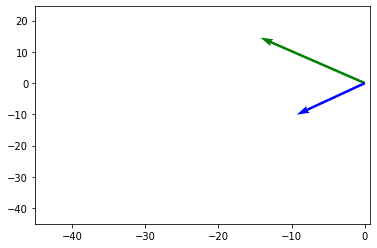

In [17]:

#Plotting CPH
gate_vector =[df_merged['LW_gate_vectors_first'][117250],df_merged['LW_gate_vectors_second'][117250]]
wind_vector =[df_merged['u_wind_vectorTWD'][117250],df_merged['v_wind_vectorTWD'][117250]]


#Plotting the vectors 
#OBS: gate vector is green, wind vector is blue.
#The vecotrs are drawnd so that they start from [0,0] and end in the vector point. 
#Meaning that the wind vector and the wind vector will always start in the same point [0,0]
vectors = np.array((gate_vector,wind_vector))
print(vectors)
tail = [0, 0]
fig, ax = plt.subplots(1)
ax.quiver(*tail,
           vectors[:, 0],
           vectors[:, 1],
           scale=1,
           scale_units='xy',
           angles = 'xy',
           color=['g', 'b'])
 
ax.set_xlim((-45, vectors[:,0].max()+10))
ax.set_ylim((-45, vectors[:,1].max()+10))

>Now we calculate the angle between the two vectors being the relative wind direction. Be aware, that the angle is calculated from the gate to the wind. 
>
>* IF angle <90 degrees, the wind is from the right, and a **left turn** is favoured. 
>
>* If angle >90 degrees, the wind is from the left, and a **right turn** is favoured. 
>
>
>

In [18]:
print(f'The relative angle between the gate line and the wind direction is', round(py_ang(gate_vector,wind_vector),2), 'degrees.')

The relative angle between the gate line and the wind direction is 92.9 degrees.


>Now calculating how many meeters are favourable. 

# 2. Meters won at gate marks

## 2.1 Meeters gain by taking left turn at LW gate (LW1 gate mark) 
> We start by having an example

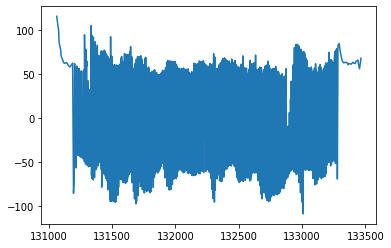

In [19]:
#Looking at the TWA for one race at upwind
df_merged.loc[df_merged['TRK_RACE_NUM_unk']==22092401.0].loc[df_merged['TRK_LEG_NUM_unk']==3]['TWA'].plot()

> Lets say for now, that all boats sail 45degrease to the wind angle. We will now draw an example

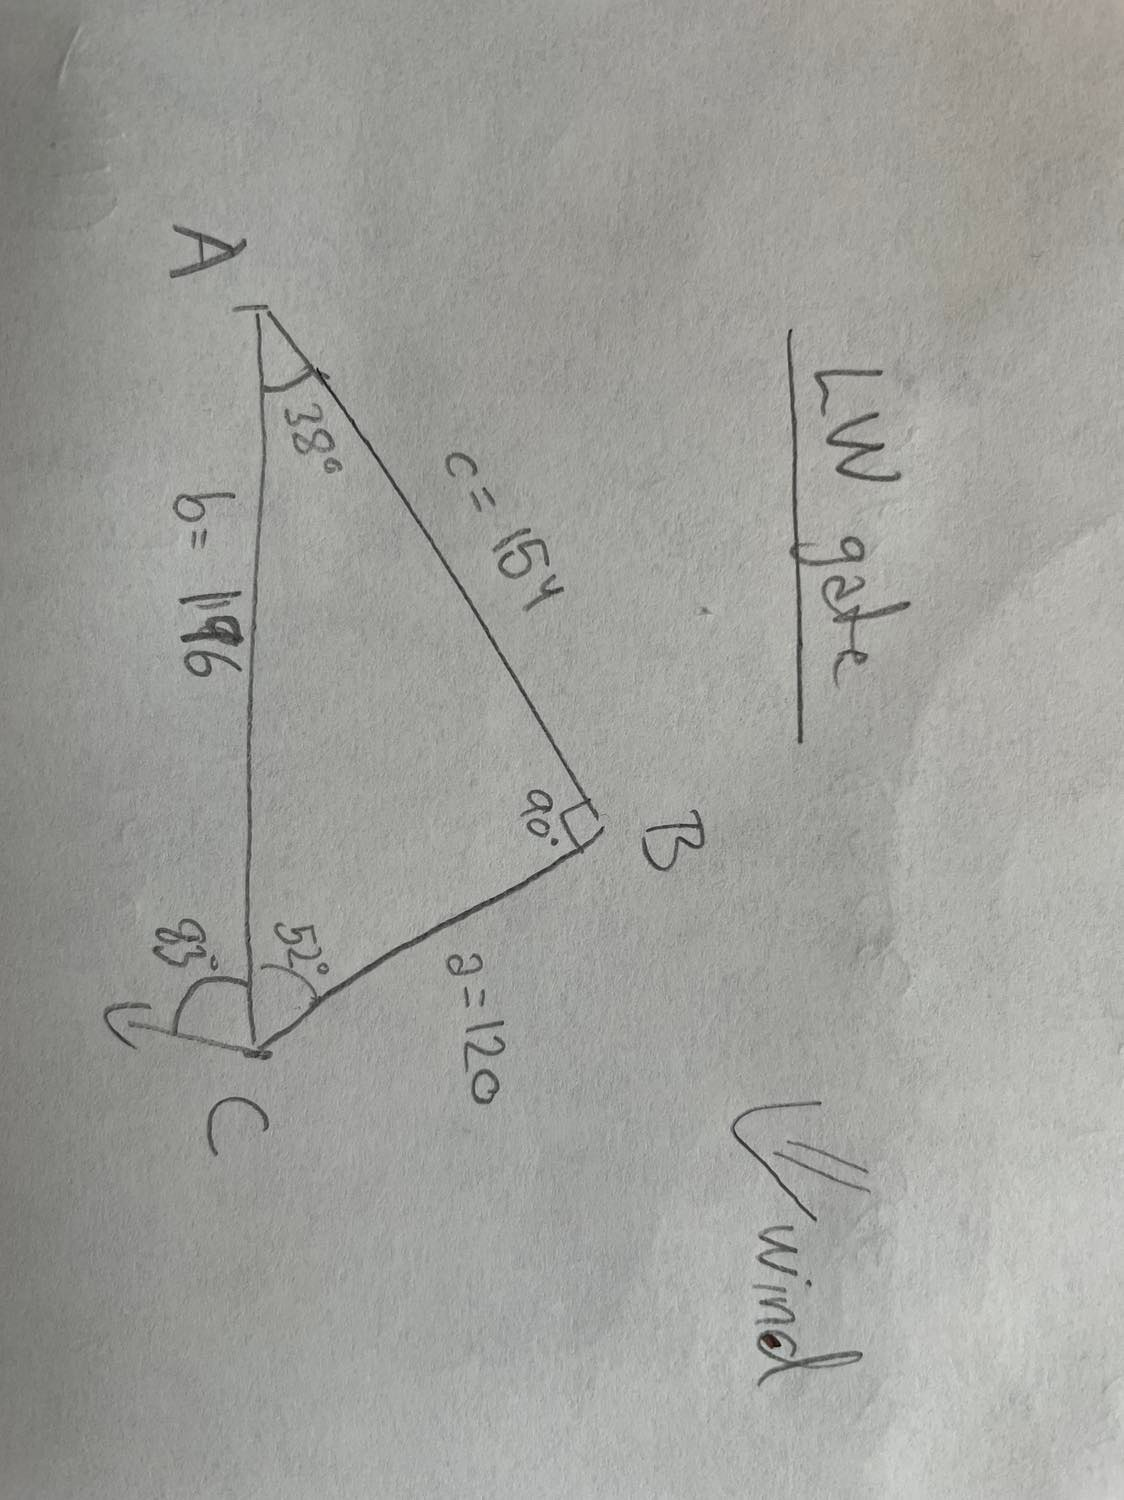

In [20]:
from IPython.display import Image
# import imutils
LWgateex=Image(filename='LWgateex.jpg',width="500", height="200")
LWgateex

>We have the following angles and distances already

>After the mark rounding, both boats tack, and we  say that the boats loose equally on the manourve, so we take that out of the equation. Meaning that now both boats are sailing against each other, 45 degrees to the wind. When they meet, we can calculate the distance sailed. Attracting those meeters from each other, we now have the meters won/lost

>First, let me just demonstrate, that boats win more meeters on upwind than on downwind due to the angles sailed to the wind. 

In [21]:



#For upwind after rounding
B=45*2 #rigtig
# print(B)
C = (180-83)-45 #rigtig! Per 5/12! :) 
print('C=',C)
b=196 #rigtig
#         print('b=',b)
c= b*math.sin(math.radians(C))/math.sin(math.radians(B)) #rigtig
print('c=',c)
A=180-B-C
print('A',A)
a= b*math.sin(math.radians(A))/math.sin(math.radians(B))
print('a=',a)
#         print('gains on upwind when taking left turn',c-a)
meters_gained_upwind_after_rounding =np.round(c-a,0)
print('meters_gained_upwind_after_rounding',meters_gained_upwind_after_rounding)



#For downwind before rounding: 

B1= 360-(140*2)#rigtig
#         print(B1)
b1= 196
#         print(b1)
C1 = (180-83)-(180-140) #rigtig YES per 5/12
#         print('C1=',C1)
c1 = b1*math.sin(math.radians(C1) )/math.sin(math.radians(B1)) #rigtig
#         print('c1=',c1)
A1=180-B1-C1 #rigtig
#         print('A1=',A1)
a1= b1*math.sin(math.radians(A1))/math.sin(math.radians(B1))#rigtig 
#         print('a1=',a1)
meters_gained_downwind_before_rounding=np.round(c1-a1,0)
print('meters_gained_downwind_before_rounding',meters_gained_downwind_before_rounding)




C= 52
c= 154.45010770691752
A 38
a= 120.66964916382902
meters_gained_upwind_after_rounding 34.0
meters_gained_downwind_before_rounding 31.0


>On top of the meeters gained on the next upwind, we of course also gain meeters on this current downwind. Hence we have to add these meters to the calculations! 

>Furter, the TWA is not precise enough. We will now use the avg TWA for the boats sailed on the leg after the rounding. That will be defined first, folloed by the meters gained by the left turn

In [22]:
#Have to make the avg of straight sailing, so removing tacks and gybes!
#Function calculating avg TWA for the legs
#
max_TWA_DW = 150
min_TWA_DW= 110
max_TWA_UW = 70
min_TWA_UW= 40
def cal_avg_TWA(data):
    avg_leg_TWA = []
    TRK_LEG_NUM_unk = []
    TRK_RACE_NUM_unk = []
    dataframe = pd.DataFrame()
    race_number = list(data['TRK_RACE_NUM_unk'].unique())
    leg_number = list(data['TRK_LEG_NUM_unk'].unique())
    boat_number = list(data['BOAT'].unique())

    for race in range(len(race_number)):
        for leg in range(len(leg_number)):
            if leg in [2,4]:
#Making sure that odd TWA's are not included, so that ex. tacks and gybes are exclusice. 
                dataframe_to_use = data.loc[data['TWA'].abs()>=abs(min_TWA_DW)]
                dataframe_to_use = dataframe_to_use.loc[dataframe_to_use['TWA'].abs()<=abs(max_TWA_DW)]
                dataframe_to_use = dataframe_to_use.loc[dataframe_to_use['TRK_RACE_NUM_unk']==race_number[race]]
                dataframe_to_use = dataframe_to_use.loc[dataframe_to_use['TRK_LEG_NUM_unk']==leg_number[leg]].reset_index(drop=True)
                dataframe_to_use['TWA']= abs(dataframe_to_use['TWA'])
            
                avg_leg_TWA.append(dataframe_to_use['TWA'].mean())
                TRK_RACE_NUM_unk.append(race_number[race])
                TRK_LEG_NUM_unk.append(leg_number[leg])
                
            elif leg in [3,5]:
#Making sure that odd TWA's are not included, so that ex. tacks and gybes are exclusice. 
                dataframe_to_use = data.loc[data['TWA'].abs()>=abs(min_TWA_UW)]
                dataframe_to_use = dataframe_to_use.loc[dataframe_to_use['TWA'].abs()<=abs(max_TWA_UW)]
                dataframe_to_use = dataframe_to_use.loc[dataframe_to_use['TRK_RACE_NUM_unk']==race_number[race]]
                dataframe_to_use = dataframe_to_use.loc[dataframe_to_use['TRK_LEG_NUM_unk']==leg_number[leg]].reset_index(drop=True)
                dataframe_to_use['TWA']= abs(dataframe_to_use['TWA'])
            
                avg_leg_TWA.append(dataframe_to_use['TWA'].mean())
                TRK_RACE_NUM_unk.append(race_number[race])
                TRK_LEG_NUM_unk.append(leg_number[leg])
    dataframe['avg_leg_TWA']=avg_leg_TWA
    dataframe['TRK_RACE_NUM_unk']=TRK_RACE_NUM_unk
    dataframe['TRK_LEG_NUM_unk']=TRK_LEG_NUM_unk
    
    return(dataframe)


In [23]:
df_avg_leg_TWA = cal_avg_TWA(df_merged)

>Now we need to make a column containing the avg_leg_TWA for the next leg: 

In [24]:
avg_leg_TWA_next_leg = []
for i in range(1,len(df_avg_leg_TWA)):
#     print(i)

    avg_leg_TWA_next_leg.append(df_avg_leg_TWA['avg_leg_TWA'][i])
avg_leg_TWA_next_leg.append(0)
df_avg_leg_TWA['avg_leg_TWA_next_leg']=avg_leg_TWA_next_leg

>Now merging df_avg_leg_TWA with df_merged

In [25]:
#Now merging df_avg_leg_TWA and df_merged
df_merged = pd.merge(df_merged,df_avg_leg_TWA, on=['TRK_RACE_NUM_unk','TRK_LEG_NUM_unk'], how='left')

>When calculating the meters gained by a rounding, we have to account for both downwind gains and upwind gains. This is two different triangles calculations where we in the end have to add the gains together: 

In [26]:
#dENNE ER KORREKT


def calc_meters_gain_LW_left_turn(data,rel_wind_angle,new_name):

#     B=100
    meters_gained =[]
    for row in range(len(data)):
        if data['TRK_LEG_NUM_unk'][row] in [2,4]:

            #For upwind after rounding
            B=data['avg_leg_TWA_next_leg'][row]*2 #rigtig
    #         print(B)
            # C = 360-df_merged['rel_wind_angle_LWgateTWD'][1500]-180-df_merged['avg_leg_TWA_next_leg'][1500]
            C = (180-data[rel_wind_angle][row])-data['avg_leg_TWA_next_leg'][row]#rigtig! Per 5/12! :) 
    #         print('C=',C)
            b= data['dist_betwen_LW_marks'][row] #rigtig
    #         print('b=',b)
            c= b*math.sin(math.radians(C))/math.sin(math.radians(B)) #rigtig
    #         print('c=',c)
            A=180-B-C
    #         print(A)
            a= b*math.sin(math.radians(A))/math.sin(math.radians(B))
    #         print('a=',a)
    #         print('gains on upwind when taking left turn',c-a)
            meters_gained_upwind_after_rounding =(c-a)
#             print('meters_gained_upwind_after_rounding',meters_gained_upwind_after_rounding)



            #For downwind before rounding: 

            B1= 360-(data['avg_leg_TWA'][row]*2)#rigtig
    #         print(B1)
            b1= data['dist_betwen_LW_marks'][row]
    #         print(b1)
            C1 = (180-data[rel_wind_angle][row])-(180-data['avg_leg_TWA'][row]) #rigtig YES per 5/12
    #         print('C1=',C1)
            c1 = b1*math.sin(math.radians(C1) )/math.sin(math.radians(B1)) #rigtig
    #         print('c1=',c1)
            A1=180-B1-C1 #rigtig
    #         print('A1=',A1)
            a1= b1*math.sin(math.radians(A1))/math.sin(math.radians(B1))#rigtig 
    #         print('a1=',a1)
            meters_gained_downwind_before_rounding=(c1-a1)
#             print('meters_gained_downwind_before_rounding',meters_gained_downwind_before_rounding)
            meters_gained.append(np.round(meters_gained_upwind_after_rounding+meters_gained_downwind_before_rounding,0))
        else:
            meters_gained.append(0)
            
    data[new_name] = meters_gained
    
    return(data)








In [27]:
df_merged = calc_meters_gain_LW_left_turn(df_merged,'rel_wind_angle_LWgateTWD','mtr_gain_by_LG1TWD')

## 2.2 Meeters gain by taking left turn at top gate (WW gate) 

[[-14.256       14.562     ]
 [ -9.29932747 -10.07405621]]


(-45, 24.56200000000507)

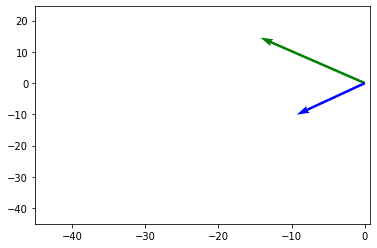

In [28]:

#Plotting CPH
gate_vector =[df_merged['LW_gate_vectors_first'][117250],df_merged['LW_gate_vectors_second'][117250]]
wind_vector =[df_merged['u_wind_vectorTWD'][117250],df_merged['v_wind_vectorTWD'][117250]]


#Plotting the vectors 
#OBS: gate vector is green, wind vector is blue.
#The vecotrs are drawnd so that they start from [0,0] and end in the vector point. 
#Meaning that the wind vector and the wind vector will always start in the same point [0,0]
vectors = np.array((gate_vector,wind_vector))
print(vectors)
tail = [0, 0]
fig, ax = plt.subplots(1)
ax.quiver(*tail,
           vectors[:, 0],
           vectors[:, 1],
           scale=1,
           scale_units='xy',
           angles = 'xy',
           color=['g', 'b'])
 
ax.set_xlim((-45, vectors[:,0].max()+10))
ax.set_ylim((-45, vectors[:,1].max()+10))

>Looking at this plot, we can  see that when wind is left of the courses axis, we want to take right turn at the top gate. 
>
>* IF angle <90 degrees, the wind is from the right, and a **left turn** is favoured. 
>
>* If angle >90 degrees, the wind is from the left, and a **right turn** is favoured. 

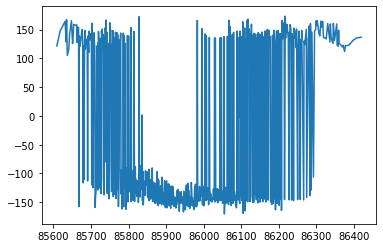

In [29]:
df_merged.loc[df_merged['TRK_RACE_NUM_unk']==22082003.0].loc[df_merged['TRK_LEG_NUM_unk']==2]['TWA'].plot()

> Lets say for now, that all boats sail 150 degrease to the wind angle. We will now draw an example

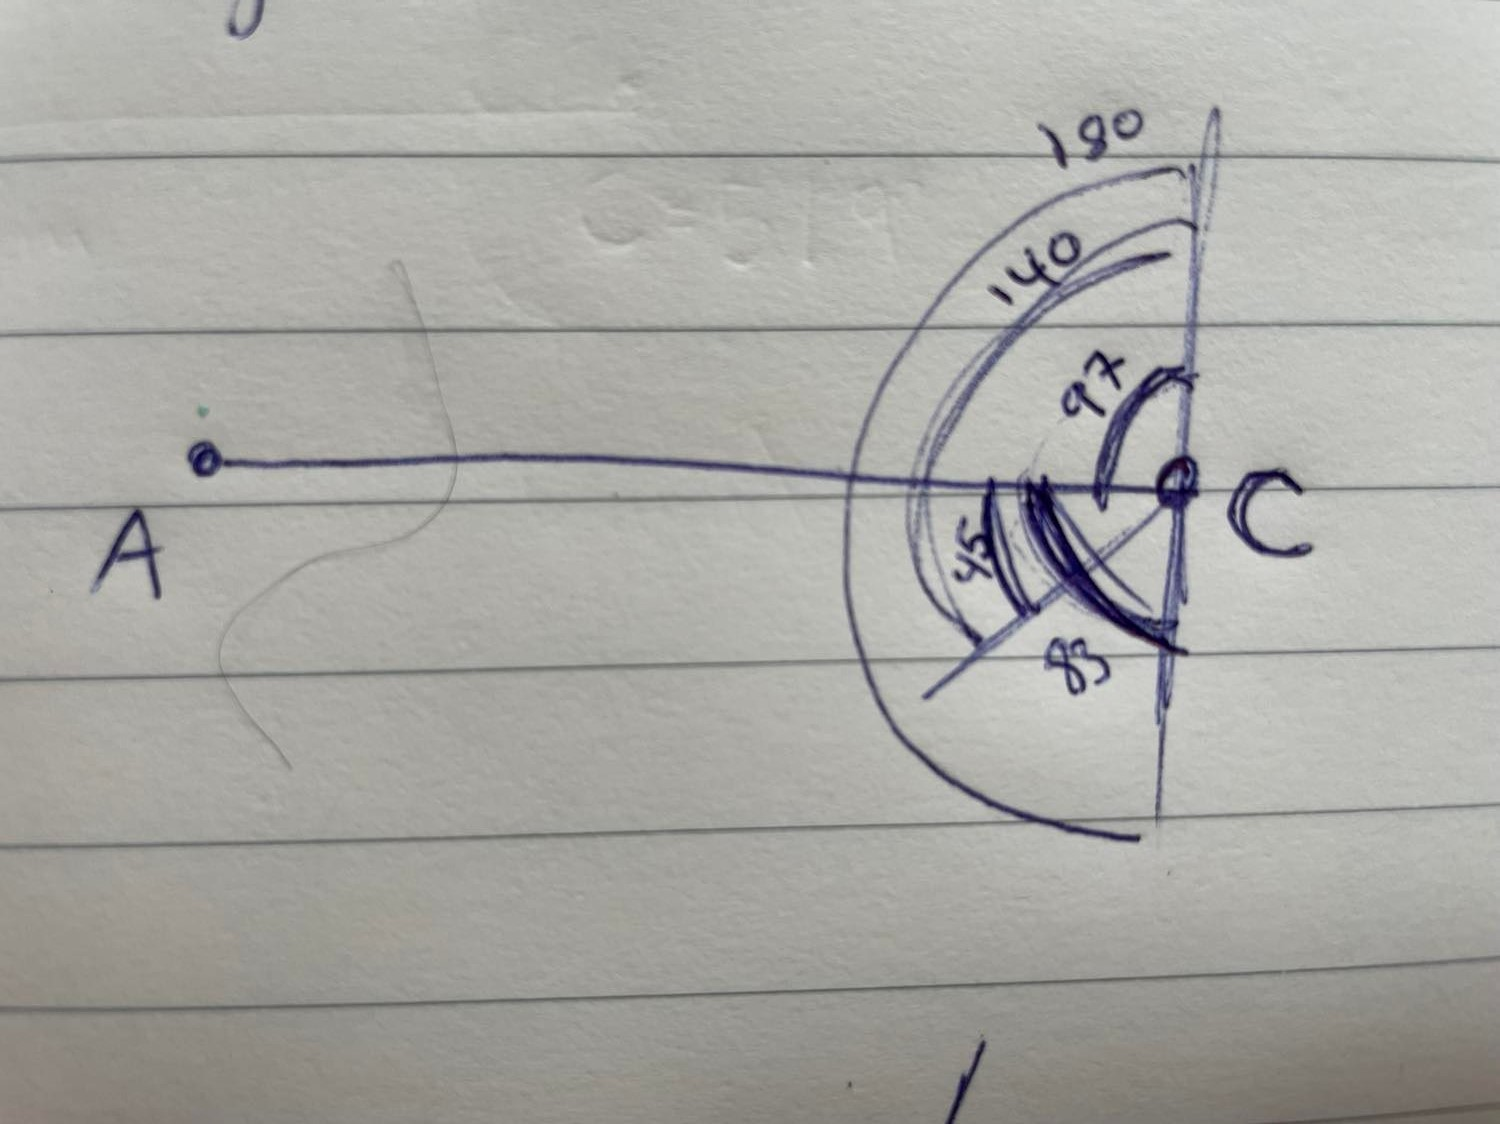

In [30]:
from IPython.display import Image
# import imutils
LWgateex=Image(filename='WWgateex.jpg',width="500", height="200")
LWgateex

>We have the following angles and distances already

>Again, I will just demonstrate that boats win more meters on upwind than on downwind by taking the biased gate. This is due to the angles sailed to the wind. 

In [31]:

#First on downwind after roudning
B=360-(140*2)
C = 140-(180-87.8) #DENNE RE RIGTIGT 05/12

b= 200
c= b/math.sin(math.radians(B))*math.sin(math.radians(C))

A=180-B-C
a= b*math.sin(math.radians(A))/math.sin(math.radians(B))
#             print('a=',a)
#             print('c=',c)
meters_gained_downwind_after_rounding = (np.round(a-c,1))

print('meters_gained_downwind_after_rounding',meters_gained_downwind_after_rounding)

#       Now upwind before rounding: 

B1= 45*2 #rigtig

C1 = 180 - (180 - 87.8)-45 #RIGTIG PER 5/12 
#         print('C=',C)
b1= 200 #rigtig
#         print('b=',b)
c1= b1*math.sin(math.radians(C1))/math.sin(math.radians(B1)) #rigtig

#             print('c1=',c1)
A1=180-B1-C1
#         print(A)
a1= b1*math.sin(math.radians(A1))/math.sin(math.radians(B1))
#             print('a1=',a1)

meters_gained_upwind_before_rounding =(a1-c1)
print('meters_gained_upwind_before_rounding',meters_gained_upwind_before_rounding)

meters_gained_downwind_after_rounding 10.0
meters_gained_upwind_before_rounding 10.857712048271992


>And therefore, it is beneficial with 47 meters to take left turn at top WW gate, and therefore WG2. We have to add the meters gained on the upwind before rounding the mark as well- This is done in the function below. Lets put this into the dataframe:

In [32]:
#this is now correct!
def calc_meters_gain_WW_left_turn(data,rel_wind_angle,new_name):
#     degrees_to_wind_downwind = 140
    
    
    meters_gained =[]
    for row in range(len(data)):
        if data['TRK_LEG_NUM_unk'][row] in [3]:

            #First on downwind after roudning
            B=360-(data['avg_leg_TWA_next_leg'][row]*2)
            C = data['avg_leg_TWA_next_leg'][row]-(180-data[rel_wind_angle][row]) #DENNE RE RIGTIGT 05/12
            b= data['dist_betwen_WW_marks'][row]
            c= b/math.sin(math.radians(B))*math.sin(math.radians(C))
            A=180-B-C
            a= b*math.sin(math.radians(A))/math.sin(math.radians(B))
#             print('a=',a)
#             print('c=',c)
            meters_gained_downwind_after_rounding = (np.round(a-c,1))
#             print('meters_gained_downwind_after_rounding',meters_gained_downwind_after_rounding)

    #       Now upwind before rounding: 

            B1= data['avg_leg_TWA'][row]*2 #rigtig

            C1 = 180 - (180 - data[rel_wind_angle][row])-data['avg_leg_TWA'][row] #RIGTIG PER 5/12 
    #         print('C=',C)
            b1= data['dist_betwen_WW_marks'][row] #rigtig
    #         print('b=',b)
            c1= b1*math.sin(math.radians(C1))/math.sin(math.radians(B1)) #rigtig

#             print('c1=',c1)
            A1=180-B1-C1
    #         print(A)
            a1= b1*math.sin(math.radians(A1))/math.sin(math.radians(B1))
#             print('a1=',a1)

            meters_gained_upwind_before_rounding =(a1-c1)
#             print('meters_gained_upwind_before_rounding',meters_gained_upwind_before_rounding)
            meters_gained.append(np.round(meters_gained_downwind_after_rounding+meters_gained_upwind_before_rounding,0))
        else: 
            meters_gained.append(0)
    
    
    
    data[new_name] = meters_gained
    
    return(data)


In [33]:
df_merged= calc_meters_gain_WW_left_turn(df_merged,'rel_wind_angle_WWgateTWD','mtr_gain_by_WG2TWD')

## 2.3 Subconclusion
>
>Looking at the calculated numbers, when the course axis is scuewed from the wind, there will be a gate bias for both WW and LW gates: 
>
>* IF angle <90 degrees, the wind is from the right, and a **left turn** is favoured. 
>
>* If angle >90 degrees, the wind is from the left, and a **right turn** is favoured. 
>
>But, this is all dependent on having the right TWD. Let's plot a TWD for the boats on in cadiz day 2, race 5, leg 2. 

# 3 Detecting TWD

> Now let us look into TWD

In [34]:
#define race and leg and all the boats
race_number = 22111304.0
leg = 2

den=df_merged.loc[df_merged['BOAT']=='DEN'].loc[df_merged['TRK_RACE_NUM_unk']==race_number].loc[df_merged['TRK_LEG_NUM_unk']==leg]

nzl=df_merged.loc[df_merged['BOAT']=='NZL'].loc[df_merged['TRK_RACE_NUM_unk']==race_number].loc[df_merged['TRK_LEG_NUM_unk']==leg]

fra=df_merged.loc[df_merged['BOAT']=='FRA'].loc[df_merged['TRK_RACE_NUM_unk']==race_number].loc[df_merged['TRK_LEG_NUM_unk']==leg]

aus=df_merged.loc[df_merged['BOAT']=='AUS'].loc[df_merged['TRK_RACE_NUM_unk']==race_number].loc[df_merged['TRK_LEG_NUM_unk']==leg]


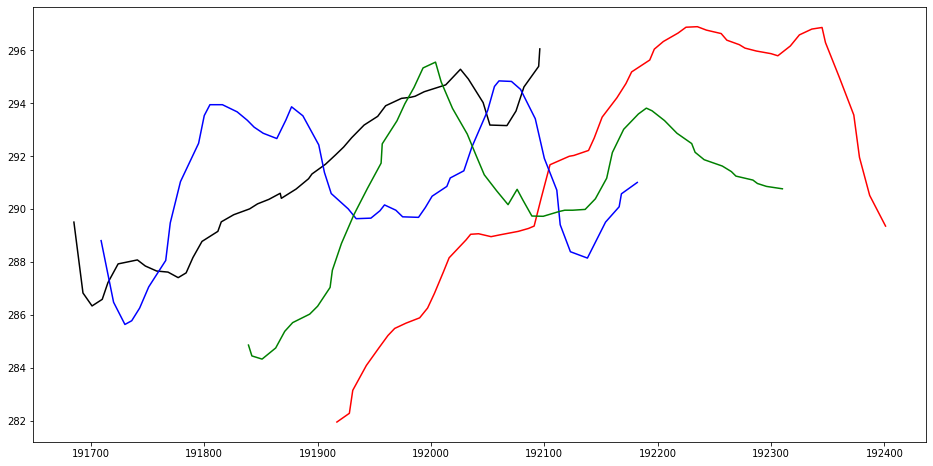

In [35]:
#Plotting four boats TWD
den['TWD'].plot(color='r',figsize=(16,8))
nzl['TWD'].plot(color='black')
fra['TWD'].plot(color='b')
aus['TWD'].plot(color='g')

>OK. We can see that on just one downwind, the TWD varies greatly from 220 to 250 - 30 degrees. Since only few degrees can be important when choosing the marks, we need to detect this area more.
> 
>Let's look at the boat speed for the same leg

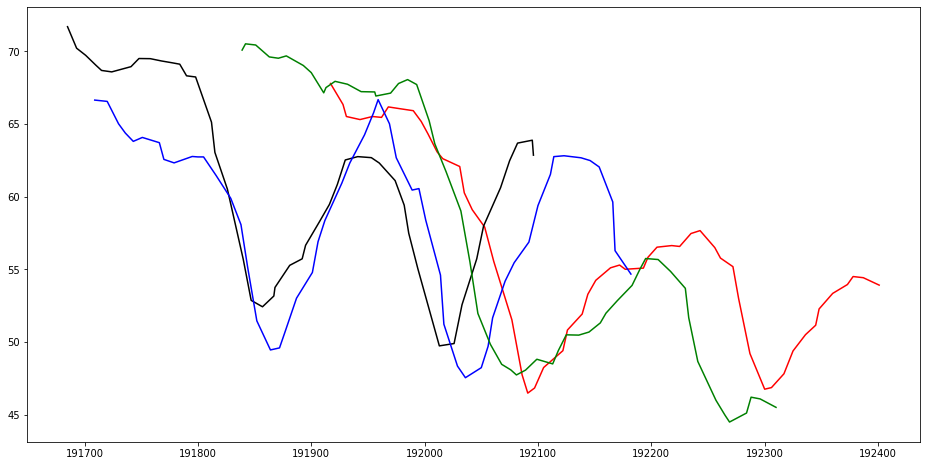

In [36]:
den.loc[den['TRK_LEG_NUM_unk']==2]['BSP_kmh'].plot(color='r',figsize=(16,8))
nzl.loc[nzl['TRK_LEG_NUM_unk']==2]['BSP_kmh'].plot(color='black')
fra.loc[fra['TRK_LEG_NUM_unk']==2]['BSP_kmh'].plot(color='b')
aus.loc[aus['TRK_LEG_NUM_unk']==2]['BSP_kmh'].plot(color='g')



>OK: We can see that boatspeed also varies much. One factor is that the boats are making a manourvre, which the wind gear has a hard time calculating into the function of TWD. Hence in these perioeds, the TWD will be off. 
>
>We now wish to calculate one true TWD for each leg and see which method is most reliant. 

## 3.1 TWD vs TWD_TM_deg
>
>Now lets detect TWD__TM_deg vs TWD and see how different these two are to eachother

In [37]:
df_den = df_merged.loc[df_merged['BOAT']=='DEN']
df_den_race=df_den.loc[df_den['TRK_RACE_NUM_unk']==race_number]



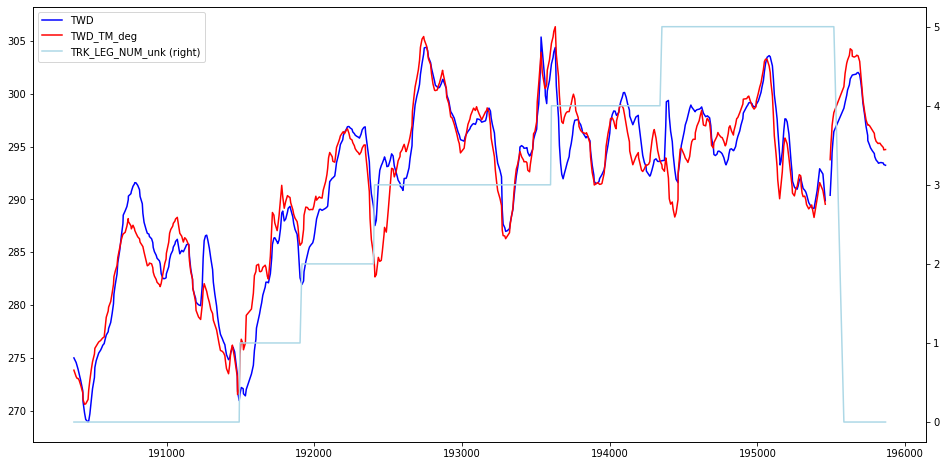

In [38]:
import matplotlib.pyplot as plt # Impot the relevant module

fig, ax = plt.subplots(figsize=(16,8)) # Create the figure and axes object


# Plot the first x and y axes:
df_den_race.plot( y = 'TWD', ax = ax,color='b')
# Plot the first x and y axes:
df_den_race.plot( y = 'TWD_TM_deg', ax = ax, color='r')

# Plot the second x and y axes. By secondary_y = True a second y-axis is requested:
# (see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html for details)
df_den_race.plot(y = 'TRK_LEG_NUM_unk', ax = ax, secondary_y = True,color='lightblue') 

In [39]:
df_TWD_vs_TM = np.round(df_den[['TRK_RACE_NUM_unk','TRK_LEG_NUM_unk','TWD','TWD_TM_deg']].groupby(['TRK_RACE_NUM_unk','TRK_LEG_NUM_unk']).median(),0)

>Now looking at the difference between TWD and TWD_TM_deg 

In [40]:
df_TWD_vs_TM['difference']= abs(df_TWD_vs_TM['TWD']-df_TWD_vs_TM['TWD_TM_deg'])

In [41]:
df_TWD_vs_TM

TWD  TWD_TM_deg  difference
TRK_RACE_NUM_unk TRK_LEG_NUM_unk                               
22061801.0       0.0              351.0       350.0         1.0
                 1.0              349.0       348.0         1.0
                 2.0              350.0       349.0         1.0
                 3.0              352.0       351.0         1.0
                 4.0              355.0       352.0         3.0
                 5.0              357.0       354.0         3.0
22061802.0       0.0                5.0        10.0         5.0
                 1.0              358.0        20.0       338.0
                 2.0              357.0       354.0         3.0
                 3.0                3.0         7.0         4.0
                 4.0              357.0       354.0         3.0
                 5.0                5.0         6.0         1.0
22061803.0       0.0              349.0       353.0         4.0
                 1.0              356.0         6.0       350.0
                 2.0              356.0       350.0         6.0
                 3.0              354.0       350.0         4.0
                 4.0              356.0       354.0         2.0
                 5.0              356.0       350.0         6.0
22061904.0       0.0               90.0        90.0         0.0
                 1.0               87.0        91.0         4.0
                 2.0               80.0        79.0         1.0
                 3.0               89.0        91.0         2.0
                 4.0               87.0        86.0         1.0
                 5.0               87.0        95.0         8.0
22061905.0       0.0               88.0        92.0         4.0
                 1.0               84.0        88.0         4.0
                 2.0               87.0        89.0         2.0
                 3.0               96.0        96.0         0.0
                 4.0               97.0        97.0         0.0
                 5.0               92.0        92.0         0.0
22073001.0       0.0              199.0       200.0         1.0
                 1.0              205.0       205.0         0.0
                 2.0              196.0       196.0         0.0
                 3.0              203.0       203.0         0.0
                 4.0              200.0       200.0         0.0
                 5.0              202.0       202.0         0.0
22073002.0       0.0              221.0       221.0         0.0
                 1.0              220.0       221.0         1.0
                 2.0              215.0       215.0         0.0
                 3.0              220.0       220.0         0.0
                 4.0              224.0       224.0         0.0
                 5.0              227.0       227.0         0.0
22073003.0       0.0              229.0       229.0         0.0
                 1.0              239.0       240.0         1.0
                 2.0              232.0       232.0         0.0
                 3.0              230.0       230.0         0.0
                 4.0              231.0       231.0         0.0
                 5.0              236.0       236.0         0.0
22073104.0       0.0              240.0       240.0         0.0
                 4.0              270.0       269.0         1.0
22073105.0       0.0              291.0       292.0         1.0
                 1.0              252.0       252.0         0.0
                 2.0              247.0       247.0         0.0
                 3.0              252.0       252.0         0.0
                 4.0              247.0       247.0         0.0
                 5.0              255.0       255.0         0.0
22082001.0       0.0                7.0         6.0         1.0
                 1.0                3.0         3.0         0.0
                 2.0               12.0        12.0         0.0
                 3.0               10.0        10.0         0.0
                 4.0                6.0         7.0         1.0
    

>OK. looking at the differencein in the two variables, we see that it varies quite a lot. However, the biggest variation was seen in the beginning of the season (with values up to 100 degrees difference). The last five events there are very small difference, hence we will just continue with the notmal TWD as out TWD. 

## 3.2 Calculating True TWD
> First off, we can  clearly see that whilst making a manouvre, the TWD is not correct. Hence we need to discard the data where a boat is making a manouvre. 

### 3.2.1 One boat at a time
>OK: Its almost impossible to agree on one TWD. Further, as a sailor, I cannot use the information from other boats when sailing. Hence it is acctually most important to just have the information of our own boat: The danish boat. Lets now look at only DEN and try to draw conclusions here. 

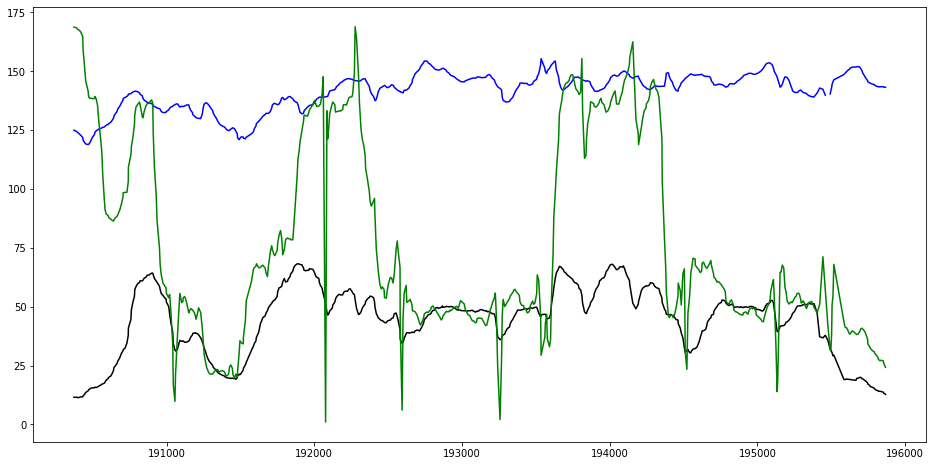

In [42]:
den=df_merged.loc[df_merged['BOAT']=='DEN'].loc[df_merged['TRK_RACE_NUM_unk']==race_number]#.loc[df_TWD['TRK_LEG_NUM_unk']==leg]
# den=den.loc[den['TRK_LEG_NUM_unk']==2].loc[den.loc[den['TRK_LEG_NUM_unk']==2]['TWA'].abs()>=abs(min_TWA)].loc[den.loc[den['TRK_LEG_NUM_unk']==2]['TWA'].abs()<=abs(max_TWA)]#.describe()
# den = den.loc[den['TRK_LEG_NUM_unk']==2]
# den['TWS_kmh'].plot(color='r',figsize=(16,8))
den['BSP_kmh'].plot(color='black',figsize=(16,8))
((den['TWD']-150)).plot(color='b',figsize=(16,8))
(abs(den['TWA'])).plot(color='g',figsize=(16,8))


In [43]:
den['TWD'].median()

293.47

>OK. The following rules are that TWA should not be less that 130 and more than 150 to make sure that we are neither in a manouvre or in a big dip or turn up for another boat, which makes it difficult to get a precise TWD for the wind gear: 

In [44]:

den=den.loc[den['TRK_LEG_NUM_unk']==2].loc[den.loc[den['TRK_LEG_NUM_unk']==2]['TWA'].abs()>=abs(min_TWA_DW)].loc[den.loc[den['TRK_LEG_NUM_unk']==2]['TWA'].abs()<=abs(max_TWA_DW)]#.describe()

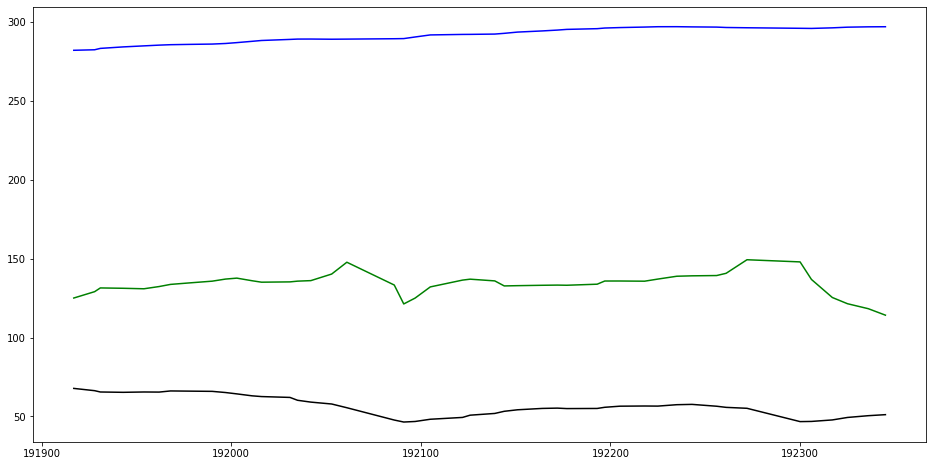

In [45]:
# den=df_merged.loc[df_merged['BOAT']=='DEN'].loc[df_merged['TRK_RACE_NUM_unk']==race_number]#.loc[df_TWD['TRK_LEG_NUM_unk']==leg]
# den['TWS_kmh'].plot(color='r',figsize=(16,8))
den['BSP_kmh'].plot(color='black',figsize=(16,8))
# den['TWD'].median().plot(color='lightblue',figsize=(16,8))
((den['TWD'])).plot(color='b',figsize=(16,8))
(abs(den['TWA'])).plot(color='g',figsize=(16,8))

>Above plot looks more meaningful, hence we will continue with those rules. 

In [46]:
den['TWD'].median()

292.015

>So, for each boat we should now have a mean TWD for each leg. 

## 3.3 Create a column with median_TWD_leg

In [47]:
 
#Creating dataframe with one boat,race,leg. This is the input, the output is the dataframe. 
race_number = list(df_merged['TRK_RACE_NUM_unk'].unique())
leg_number = list(df_merged['TRK_LEG_NUM_unk'].unique())
boat_number = list(df_merged['BOAT'].unique())

def avg_TWD_leg(data,boat,race,leg):
    new_dataframe = pd.DataFrame()
    boat_list = []
    race_number_list = []
    leg_number_list = []
    data_to_use = data.loc[data['BOAT']==boat]
    data_to_use = data_to_use.loc[data_to_use['TRK_RACE_NUM_unk']==race]
    
    data_to_use = data_to_use.loc[data_to_use['TRK_LEG_NUM_unk']==leg]
    median_TWD = data_to_use['TWD'].median()
    boat_list.append(boat)
    race_number_list.append(race)
    leg_number_list.append(leg)
        
    new_dataframe['BOAT']=boat_list
    new_dataframe['TRK_RACE_NUM_unk']=race_number_list
    new_dataframe['TRK_LEG_NUM_unk']=leg_number_list       
    new_dataframe['median_TWD']=median_TWD
        

    return(new_dataframe)


In [48]:
#Now adding all boats, races and legs together to one datafrae. 
# Here we apply the rule that you have to be within a TWA for the TWD to count. 

race_number = list(df_merged['TRK_RACE_NUM_unk'].unique())
leg_number = list(df_merged['TRK_LEG_NUM_unk'].unique())
boat_number = list(df_merged['BOAT'].unique())
df_median_TWD = pd.DataFrame()
max_TWA_DW = 150
min_TWA_DW= 110
max_TWA_UW = 70
min_TWA_UW= 40
for raceid in race_number:
    for legid in leg_number:
        for boatid in boat_number:
            if legid in [2,4]:
                #Making sure that odd TWA's are not included, so that ex. tacks and gybes are exclusice. 
                data = df_merged.loc[df_merged['TWA'].abs()>=abs(min_TWA_DW)]
                data = df_merged.loc[df_merged['TWA'].abs()<=abs(max_TWA_DW)]
                TWD_midlertidig=avg_TWD_leg(data,boatid,raceid,legid)
                df_median_TWD=df_median_TWD.append(TWD_midlertidig)
            elif legid in [3]:
                data = df_merged.loc[df_merged['TWA'].abs()>=abs(min_TWA_UW)]
                data = df_merged.loc[df_merged['TWA'].abs()<=abs(max_TWA_UW)]
                TWD_midlertidig=avg_TWD_leg(data,boatid,raceid,legid)
                df_median_TWD=df_median_TWD.append(TWD_midlertidig)
            else: 
                TWD_midlertidig=avg_TWD_leg(df_merged,boatid,raceid,legid)
                df_median_TWD=df_median_TWD.append(TWD_midlertidig)
                
            

In [49]:
df_median_TWD

,BOAT,TRK_RACE_NUM_unk,TRK_LEG_NUM_unk,median_TWD
0,GBR,22061801.0,0.0,352.340
0,CAN,22061801.0,0.0,352.200
0,SUI,22061801.0,0.0,351.565
0,AUS,22061801.0,0.0,352.250
0,ESP,22061801.0,0.0,353.730
0,USA,22061801.0,0.0,345.000
0,FRA,22061801.0,0.0,353.560
0,DEN,22061801.0,0.0,351.390
0,NZL,22061801.0,0.0,352.380
0,GBR,22061801.0,1.0,350.970


### 3.3.1Now merging the df_median_TWD and df_merged

In [50]:
#Now merging df_TWD and df_merged
df_merged1 = pd.merge(df_merged,df_median_TWD, on=['BOAT','TRK_RACE_NUM_unk','TRK_LEG_NUM_unk'], how='left')


> We will now get the meeters gained by using the median_TWD instead of the TWD. We will use the functions defined earlier. 

In [51]:
df_merged1 = calc_u_v_vector(df_merged1,'median_TWD')
df_merged1 =calc_rel_wind_angle_LG(df_merged1,'median_TWD')
df_merged1 =calc_rel_wind_angle_WG(df_merged1,'median_TWD')
df_merged1=calc_meters_gain_LW_left_turn(df_merged1,'rel_wind_angle_LWgatemedian_TWD','mtr_gain_by_LWG1median_TWD')
df_merged1= calc_meters_gain_WW_left_turn(df_merged1,'rel_wind_angle_WWgatemedian_TWD','mtr_gain_by_WWG2median_TWD')

In [52]:
df_merged1=calc_meters_gain_LW_left_turn(df_merged1,'rel_wind_angle_LWgatemedian_TWD','mtr_gain_by_LWG1median_TWD')


In [53]:
df_merged1= calc_meters_gain_WW_left_turn(df_merged1,'rel_wind_angle_WWgatemedian_TWD','mtr_gain_by_WWG2median_TWD')

In [54]:
df_merged1.head()

,BOAT,DATETIME,Latitude,Longitude,BSP_kmh,TWS_kmh,TWD,TWD_TM_deg,TWA,TRK_RACE_NUM_unk,TRK_LEG_NUM_unk,PC_TTB_s,PC_TTK_s,TTS_s,extra,unk_race_ID,POSITION_AT_LAST_MARK*,DELTA,date_column,WW_gate_vectors_first,WW_gate_vectors_second,LW_gate_vectors_first,LW_gate_vectors_second,WG1_long,WG1_lat,WG2_long,WG2_lat,LG1_long,LG1_lat,LG2_long,LG2_lat,Place,dist_betwen_LW_marks,dist_betwen_WW_marks,u_wind_vectorTWD,v_wind_vectorTWD,rel_wind_angle_LWgateTWD,rel_wind_angle_WWgateTWD,avg_leg_TWA,avg_leg_TWA_next_leg,mtr_gain_by_LG1TWD,mtr_gain_by_WG2TWD,median_TWD,u_wind_vectormedian_TWD,v_wind_vectormedian_TWD,rel_wind_angle_LWgatemedian_TWD,rel_wind_angle_WWgatemedian_TWD,mtr_gain_by_LWG1median_TWD,mtr_gain_by_WWG2median_TWD
0,GBR,2022-06-18 19:12:01,41.888381,-87.590905,15.72,28.88,344.71,340.19,-147.26,22061801.0,0.0,146.06,102.95,119.40,1.0,2022-06-18 19:12:01,NaN,-77.0,2022-06-18,-7.44,0.024,-21.825,-0.9,-87.594043,41.891106,-87.595903,41.891112,-87.593217,41.876205,-87.595642,41.876105,chicago,270.9,207.7,7.615792,-27.857748,102.9,105.5,NaN,NaN,0.0,0.0,352.340,3.849540,-28.622289,95.3,97.8,0.0,0.0
1,CAN,2022-06-18 19:12:01,41.888182,-87.592916,61.08,25.33,0.40,357.96,-73.31,22061801.0,0.0,65.12,116.65,119.50,1.0,2022-06-18 19:12:01,NaN,-3.0,2022-06-18,-7.44,0.024,-21.825,-0.9,-87.594043,41.891106,-87.595903,41.891112,-87.593217,41.876205,-87.595642,41.876105,chicago,270.9,207.7,-0.176835,-25.329383,87.2,89.8,NaN,NaN,0.0,0.0,352.200,3.437675,-25.095643,95.4,98.0,0.0,0.0
2,SUI,2022-06-18 19:12:01,41.887851,-87.593025,34.13,23.18,2.67,357.32,-52.18,22061801.0,0.0,89.70,115.65,119.50,1.0,2022-06-18 19:12:01,NaN,-9.0,2022-06-18,-7.44,0.024,-21.825,-0.9,-87.594043,41.891106,-87.595903,41.891112,-87.593217,41.876205,-87.595642,41.876105,chicago,270.9,207.7,-1.079804,-23.154836,85.0,87.5,NaN,NaN,0.0,0.0,351.565,3.400212,-22.929260,96.1,98.6,0.0,0.0
3,AUS,2022-06-18 19:12:01,41.886923,-87.596583,19.70,22.68,358.01,356.70,-40.47,22061801.0,0.0,119.72,98.65,118.60,1.0,2022-06-18 19:12:01,NaN,-15.0,2022-06-18,-7.44,0.024,-21.825,-0.9,-87.594043,41.891106,-87.595903,41.891112,-87.593217,41.876205,-87.595642,41.876105,chicago,270.9,207.7,0.787565,-22.666322,89.6,92.2,NaN,NaN,0.0,0.0,352.250,3.058419,-22.472839,95.4,97.9,0.0,0.0
4,ESP,2022-06-18 19:12:01,41.883369,-87.597178,21.51,23.96,356.86,6.35,-31.50,22061801.0,0.0,295.43,58.15,118.65,1.0,2022-06-18 19:12:01,NaN,-5.0,2022-06-18,-7.44,0.024,-21.825,-0.9,-87.594043,41.891106,-87.595903,41.891112,-87.593217,41.876205,-87.595642,41.876105,chicago,270.9,207.7,1.312431,-23.924028,90.8,93.3,NaN,NaN,0.0,0.0,353.730,2.616764,-23.816678,93.9,96.5,0.0,0.0


# 4 Defining what mark the boat takes
>
>It is interesting to see, how often a boat that is rounding the biased gate mark acctually gain boats on the next upwind. This will determine the statistcs on how favourable the biased gatemark is. My hypothesis is, that rounding the right mark often gains boats - also because i might make you split with the fleet. But let's look into it. 
>
>First, we need to define whether a boat rounds the biased mark. 

In [55]:
#Calculating how many meeters to both LG1,LG2 and WG1,WG2 .
# This we will later use to say ex: if boat_to_LG1 <= 30 meter (2 boat lengths ), then the boat has taken left turn. 
# And probably add a constrain saying something about the other mark.. 
def calc_distance_to_Left_AND_right_turn(data):
    boat_to_LG1 = []
    boat_to_LG2 = []
    boat_to_WG1 = []
    boat_to_WG2 = []
    for row in range(len(data)):
##--------Calculate the distance-----##
        boat_to_LG1.append(round(geopy.distance.distance([data['LG1_long'][row],data['LG1_lat'][row]],[data['Longitude'][row],data['Latitude'][row]]).m,1))
        boat_to_WG1.append(round(geopy.distance.distance([data['WG1_long'][row],data['WG1_lat'][row]],[data['Longitude'][row],data['Latitude'][row]]).m,1))
        boat_to_LG2.append(round(geopy.distance.distance([data['LG2_long'][row],data['LG2_lat'][row]],[data['Longitude'][row],data['Latitude'][row]]).m,1))
        boat_to_WG2.append(round(geopy.distance.distance([data['WG2_long'][row],data['WG2_lat'][row]],[data['Longitude'][row],data['Latitude'][row]]).m,1))
    data['boat_to_LG1'] =  boat_to_LG1
    data['boat_to_WG1'] =  boat_to_WG1
    data['boat_to_LG2'] =  boat_to_LG2
    data['boat_to_WG2'] =  boat_to_WG2
    
    return(data)

In [56]:
df_merged1= calc_distance_to_Left_AND_right_turn(df_merged1)

>Following cell determines what mark aboat rounds. 
>
>The thought is that when we know that a boat is closer than 60 meters to a mark, it enters the zone for rounding a mark. BUT, sometimes a boat passes one mark (closer than 60 meters) and sails to the other mark. Hence we need to look at a boat when it enters 60 meters zone AND how close it is to the mark at +1 leg. This will determine the correct mark. 

In [57]:
race_number = list(df_merged1['TRK_RACE_NUM_unk'].unique())
leg_number = list(df_merged1['TRK_LEG_NUM_unk'].unique())
boat_number = list(df_merged1['BOAT'].unique())
take_LWG1= []
take_LWG2= []
take_WWG1=[]
take_WWG2=[]
boat1 = []
race1 = []
legg1 = []


dist_to_mark_after_rounding = []
dataframee = pd.DataFrame()

#Start by saving a midlertidig df for each boat and leg >2 
midlertidig_df= df_merged1.loc[df_merged1['TRK_LEG_NUM_unk']>= 2].reset_index(drop=True)
# midlertidig_df= midlertidig_df.loc[midlertidig_df['TRK_RACE_NUM_unk']== 22073105.0].reset_index(drop=True)
# midlertidig_df= midlertidig_df.loc[midlertidig_df['BOAT']== 'NZL'].reset_index()


#for each boat
for boatid in range(len(boat_number)):
#     print('hej')
    midlertidig_df1 = midlertidig_df.loc[midlertidig_df['BOAT']==boat_number[boatid]].reset_index(drop=True)
#For each race
    for raceid in range(len(race_number)):
        midlertidig_df2 = midlertidig_df1.loc[midlertidig_df1['TRK_RACE_NUM_unk']==race_number[raceid]].reset_index(drop=True)
        for row in range(len(midlertidig_df2)):
            leg = midlertidig_df2['TRK_LEG_NUM_unk'][row]
            if ((midlertidig_df2['boat_to_LG1'][row] <= 50)):
                ny_df = pd.DataFrame()
                ny_df=(ny_df.append(midlertidig_df2[row:row+6])).reset_index()
                for j in range(len(ny_df)):


                    if ny_df['TRK_LEG_NUM_unk'][j] == (leg+1):

                        dist_to_LG1_after_rounding = ny_df['boat_to_LG1'][j]
                        dist_to_LG2_after_rounding = ny_df['boat_to_LG2'][j]

# Make sure that they acctually take that mark
                        if dist_to_LG1_after_rounding < dist_to_LG2_after_rounding:
                            race1.append(race_number[raceid])
                            legg1.append(leg)
                            dist_to_mark_after_rounding.append(dist_to_LG1_after_rounding)
                            boat1.append(boat_number[boatid])
                            take_LWG1.append(1)
                            take_LWG2.append(0)
                            take_WWG1.append(0)
                            take_WWG2.append(0)

#break so that we do not continue the "if leg+1) statement 
                        break
                        
#Now do the same for LG2
            elif ((midlertidig_df2['boat_to_LG2'][row] <= 50)):
                ny_df = pd.DataFrame()
                ny_df=(ny_df.append(midlertidig_df2[row:row+6])).reset_index()
                for j in range(len(ny_df)):

                    if ny_df['TRK_LEG_NUM_unk'][j] == (leg+1):
                        dist_to_LG1_after_rounding = ny_df['boat_to_LG1'][j]
                        dist_to_LG2_after_rounding = ny_df['boat_to_LG2'][j]
# Make sure that they acctually take that mark, meaning that dist to LG1 after rounding has to be less than dist to LG2
                        if dist_to_LG1_after_rounding > dist_to_LG2_after_rounding:
                            race1.append(race_number[raceid])
                            legg1.append(leg)
                            dist_to_mark_after_rounding.append(dist_to_LG2_after_rounding)
                            boat1.append(boat_number[boatid])
                            take_LWG1.append(0)
                            take_LWG2.append(1)
                            take_WWG1.append(0)
                            take_WWG2.append(0)

                        break
                        
                        
                        
#Now do the same for WG1
            if ((midlertidig_df2['boat_to_WG1'][row] <= 50)):
                ny_df = pd.DataFrame()
                ny_df=(ny_df.append(midlertidig_df2[row:row+6])).reset_index()
                for j in range(len(ny_df)):

                    if ny_df['TRK_LEG_NUM_unk'][j] == (leg+1):
                        dist_to_WG1_after_rounding = ny_df['boat_to_WG1'][j]
                        dist_to_WG2_after_rounding = ny_df['boat_to_WG2'][j]
# Make sure that they acctually take that mark, meaning that dist to LG1 after rounding has to be less than dist to LG2
                        if dist_to_WG1_after_rounding < dist_to_WG2_after_rounding:
                            race1.append(race_number[raceid])
                            legg1.append(leg)
                            dist_to_mark_after_rounding.append(dist_to_WG1_after_rounding)
                            boat1.append(boat_number[boatid])
                            take_LWG1.append(0)
                            take_LWG2.append(0)
                            take_WWG1.append(1)
                            take_WWG2.append(0)

                            
                        break
                        
                        
#Now do the same for WG2
            elif ((midlertidig_df2['boat_to_WG2'][row] <= 50)):
                ny_df = pd.DataFrame()
                ny_df=(ny_df.append(midlertidig_df2[row:row+6])).reset_index()
                for j in range(len(ny_df)):

                    if ny_df['TRK_LEG_NUM_unk'][j] == (leg+1):
                        dist_to_WG1_after_rounding = ny_df['boat_to_WG1'][j]
                        dist_to_WG2_after_rounding = ny_df['boat_to_WG2'][j]
                        
# Make sure that they acctually take that mark, meaning that dist to LG1 after rounding has to be less than dist to LG2
                        if dist_to_WG1_after_rounding > dist_to_WG2_after_rounding:
                            race1.append(race_number[raceid])
                            legg1.append(leg)
                            dist_to_mark_after_rounding.append(dist_to_WG2_after_rounding)
                            boat1.append(boat_number[boatid])
                            take_LWG1.append(0)
                            take_LWG2.append(0)
                            take_WWG1.append(0)
                            take_WWG2.append(1)

                            
                        break
                
                        
                        
                        
#LG1
dataframee['take_LWG1']= take_LWG1
dataframee['take_LWG2']= take_LWG2
dataframee['take_WWG1']= take_WWG1
dataframee['take_WWG2']= take_WWG2
dataframee['dist_to_mark_after_rounding']= dist_to_mark_after_rounding
dataframee['BOAT']= boat1
dataframee['TRK_RACE_NUM_unk']= race1
dataframee['TRK_LEG_NUM_unk']= legg1




>The above code will create come dublicates, hence these are dropped: 

In [58]:
dataframee=dataframee.drop_duplicates().reset_index(drop=True)

In [59]:
#Now merging dataframee and df_merged1
df_merged1= pd.merge(df_merged1,dataframee, on=['BOAT','TRK_RACE_NUM_unk','TRK_LEG_NUM_unk'], how='left')

>Lets determine the meters gained by taking the mark 

In [60]:
#Biased gate meeters gained
meters_won=[]
for row in range(len(df_merged1)):
    if (df_merged1['take_LWG1'][row]==1):
        meters_won.append(df_merged1['mtr_gain_by_LWG1median_TWD'][row])
    elif (df_merged1['take_LWG2'][row]==1):
        meters_won.append(-df_merged1['mtr_gain_by_LWG1median_TWD'][row])
    elif (df_merged1['take_WWG1'][row]==1):
        meters_won.append(-df_merged1['mtr_gain_by_WWG2median_TWD'][row])
    elif (df_merged1['take_WWG2'][row]==1):
        meters_won.append(df_merged1['mtr_gain_by_WWG2median_TWD'][row])
    else: 
        meters_won.append(0)
    
df_merged1['meters_won']= meters_won
    

>And also whether or not it is the calculated biased mark

In [61]:
# Determine if boat choose biased gate
take_biased_gate=[]
for row in range(len(df_merged1)):
    if (df_merged1['meters_won'][row]>=1):  
        take_biased_gate.append(1)
    elif (df_merged1['meters_won'][row]<=1): 
        take_biased_gate.append(0)
    else:
        take_biased_gate.append(0)
df_merged1['take_biased_gate'] = take_biased_gate

>OK. Now we will look at the number of boats gained on the next leg. 

In [62]:
#Boats gained on next leg 
# ALso make a column that says how many meters was gained on takin the biased mark
def boats_gained_on_next_leg(data):
    race_number = list(data['TRK_RACE_NUM_unk'].unique())
    leg_number = list(data['TRK_LEG_NUM_unk'].unique())
    boat_number = list(data['BOAT'].unique())
    df_boats_won = pd.DataFrame()


    for race in range(len(race_number)):
        for boat in range(len(boat_number)):
            a=data.loc[data['TRK_RACE_NUM_unk']==race_number[race]]

            b=a.loc[a['BOAT']==boat_number[boat]]
            c =  b[['BOAT','TRK_RACE_NUM_unk','TRK_LEG_NUM_unk','POSITION_AT_LAST_MARK*','meters_won','take_biased_gate']]
            c = c.drop_duplicates().reset_index()
    #         print(c)
            pos= []
            racenumber = []
            boatname = []
            has_taken_biased_gate = []
            laa = pd.DataFrame()
            next_leg = []
            legg = []
            boats_won = []
            meters_won =[]
            leg =3
            for row in range(len(c)):

                if c['TRK_LEG_NUM_unk'][row]==leg:
                    leg = leg+1
                    pos.append(c['POSITION_AT_LAST_MARK*'][row])
                    has_taken_biased_gate.append(c['take_biased_gate'][row-1])
                    legg.append(c['TRK_LEG_NUM_unk'][row]-1)
                    next_leg.append(c['TRK_LEG_NUM_unk'][row])
                    racenumber.append(c['TRK_RACE_NUM_unk'][row])
                    boatname.append(c['BOAT'][row])
                    meters_won.append(c['meters_won'][row-1])



            laa['TRK_RACE_NUM_unk'] = racenumber
            laa['BOAT'] = boatname
            laa['position_at_current_gate']=pos
            laa['has_taken_biased_gate']=has_taken_biased_gate
            laa['leg_after_gate']= next_leg
            laa['TRK_LEG_NUM_unk']=legg
            laa['meters_won'] = meters_won



            for row in range(len(laa)-1):
                boats_won.append(laa['position_at_current_gate'][row]-laa['position_at_current_gate'][row+1])
            boats_won.append(0)   
#             boats_won
            laa['boats_won_on_leg_after_gate'] = boats_won
            df_boats_won=df_boats_won.append(laa)
    return(df_boats_won.reset_index(drop=True))




In [63]:
df_boats_won=boats_gained_on_next_leg(df_merged1)

>Now let us look at the number of boats won when taken the biased gate.

In [64]:
df_boats_won

,TRK_RACE_NUM_unk,BOAT,position_at_current_gate,has_taken_biased_gate,leg_after_gate,TRK_LEG_NUM_unk,meters_won,boats_won_on_leg_after_gate
0,22061801.0,GBR,2.0,1.0,3.0,2.0,60.0,0.0
1,22061801.0,GBR,2.0,1.0,4.0,3.0,94.0,0.0
2,22061801.0,GBR,2.0,0.0,5.0,4.0,-17.0,0.0
3,22061801.0,CAN,5.0,1.0,3.0,2.0,133.0,-1.0
4,22061801.0,CAN,6.0,0.0,4.0,3.0,-102.0,2.0
5,22061801.0,CAN,4.0,0.0,5.0,4.0,-72.0,0.0
6,22061801.0,SUI,7.0,1.0,3.0,2.0,82.0,2.0
7,22061801.0,SUI,5.0,1.0,4.0,3.0,58.0,0.0
8,22061801.0,SUI,5.0,0.0,5.0,4.0,-48.0,0.0
9,22061801.0,AUS,6.0,0.0,3.0,2.0,-75.0,-1.0


In [65]:
df_boats_won.loc[df_boats_won['has_taken_biased_gate']==1]['boats_won_on_leg_after_gate'].sum()

13.0

>And the boats won when thaken the **UNbiased** gate

In [66]:
df_boats_won.loc[df_boats_won['has_taken_biased_gate']==0]['boats_won_on_leg_after_gate'].sum()

3.0

>OK, looks like more boats a won when taken the bised mark.

In [67]:
df_boats_won.loc[df_boats_won['has_taken_biased_gate']==0].describe()

,TRK_RACE_NUM_unk,position_at_current_gate,has_taken_biased_gate,leg_after_gate,TRK_LEG_NUM_unk,meters_won,boats_won_on_leg_after_gate
count,3.300000e+02,314.000000,330.0,330.000000,330.000000,322.000000,318.000000
mean,2.208457e+07,5.073248,0.0,3.975758,2.975758,-65.310559,0.009434
std,1.655280e+04,2.543748,0.0,0.735149,0.735149,78.575815,1.146895
min,2.206180e+07,1.000000,0.0,3.000000,2.000000,-417.000000,-7.000000
25%,2.207300e+07,3.000000,0.0,3.000000,2.000000,-85.000000,0.000000
50%,2.209100e+07,5.000000,0.0,4.000000,3.000000,-40.000000,0.000000
75%,2.209240e+07,7.000000,0.0,5.000000,4.000000,-15.000000,0.000000
max,2.211130e+07,9.000000,0.0,5.000000,4.000000,0.000000,4.000000


In [68]:
df_boats_won.loc[df_boats_won['has_taken_biased_gate']==1].describe()

,TRK_RACE_NUM_unk,position_at_current_gate,has_taken_biased_gate,leg_after_gate,TRK_LEG_NUM_unk,meters_won,boats_won_on_leg_after_gate
count,3.470000e+02,333.000000,347.0,347.000000,347.000000,347.000000,339.000000
mean,2.208575e+07,4.669670,1.0,3.904899,2.904899,117.285303,0.038348
std,1.613260e+04,2.510018,0.0,0.863287,0.863287,101.849015,1.085817
min,2.206180e+07,1.000000,1.0,3.000000,2.000000,1.000000,-5.000000
25%,2.207300e+07,2.000000,1.0,3.000000,2.000000,41.000000,0.000000
50%,2.209100e+07,5.000000,1.0,4.000000,3.000000,85.000000,0.000000
75%,2.209250e+07,7.000000,1.0,5.000000,4.000000,154.500000,0.000000
max,2.211130e+07,9.000000,1.0,5.000000,4.000000,481.000000,5.000000


>OK this is very interesting! Almost eqaully whether you win or loose bots by taking biased mark. First, we need to how many boats are acctually won and lost instead of just taking the sum. 



>Sum of gained boats after taking the biased mark: 

In [69]:
df_boats_won.loc[df_boats_won['has_taken_biased_gate']==1].loc[df_boats_won.loc[df_boats_won['has_taken_biased_gate']==1]['boats_won_on_leg_after_gate']>=0]['boats_won_on_leg_after_gate'].sum()
    

102.0

>Sum of lost boats after taking the biased mark: 

In [70]:
df_boats_won.loc[df_boats_won['has_taken_biased_gate']==1].loc[df_boats_won.loc[df_boats_won['has_taken_biased_gate']==1]['boats_won_on_leg_after_gate']<=0]['boats_won_on_leg_after_gate'].sum()
    

-89.0

>Sum of gained boats after taking the unbiased mark: 

In [71]:
df_boats_won.loc[df_boats_won['has_taken_biased_gate']==0].loc[df_boats_won.loc[df_boats_won['has_taken_biased_gate']==0]['boats_won_on_leg_after_gate']>=0]['boats_won_on_leg_after_gate'].sum()


85.0

>Sum of lost boats after taking the unbiased mark: 

In [72]:
df_boats_won.loc[df_boats_won['has_taken_biased_gate']==0].loc[df_boats_won.loc[df_boats_won['has_taken_biased_gate']==0]['boats_won_on_leg_after_gate']<=0]['boats_won_on_leg_after_gate'].sum()


-82.0

## 4.1 Subconclusion
>OK this is interesting. First of all, the distribution of taking the biased vs unbised mark is almost 50/50. This is nice to know... However, two more boats are lost than won, when taking the biased gate mark. Looking at the unbiased mark, more boats are won than lost. 
>
>A theory is that it is because you can **get a split with the fleet, if you choose the unbiased gate mark**. We will look into this later.

>I think we should dig deaper into this and see if it is the same tendency for both WW and LW mark. 

# 5 Dividing the gate in LW_gate and WW_gate and calc boats won

In [73]:
LW_gate= df_boats_won.loc[df_boats_won['leg_after_gate'].isin([3,5])]

In [74]:
WW_gate= df_boats_won.loc[df_boats_won['leg_after_gate'].isin([4])]

In [75]:
a= LW_gate.loc[LW_gate['has_taken_biased_gate']==1]
b= a.loc[a['boats_won_on_leg_after_gate']>=0]
c=b['boats_won_on_leg_after_gate'].sum()
print(f'Boats that have rounded the biased LW gate mark win in total',c,'boats' )

a= LW_gate.loc[LW_gate['has_taken_biased_gate']==1]
b= a.loc[a['boats_won_on_leg_after_gate']<=0]
c=b['boats_won_on_leg_after_gate'].sum()
print(f'Boats that have rounded the biased LW gate mark looses in total',c,'boats' )


print(f'Boats that have rounded the biased LW gate mark win in SUMMATION ',LW_gate.loc[LW_gate['has_taken_biased_gate']==1]['boats_won_on_leg_after_gate'].sum(),'boats')

Boats that have rounded the biased LW gate mark win in total 72.0 boats
Boats that have rounded the biased LW gate mark looses in total -70.0 boats
Boats that have rounded the biased LW gate mark win in SUMMATION  2.0 boats


In [76]:
a= LW_gate.loc[LW_gate['has_taken_biased_gate']==0]
b= a.loc[a['boats_won_on_leg_after_gate']>=0]
c=b['boats_won_on_leg_after_gate'].sum()
print(f'Boats that have rounded the UNbiased LW gate mark win in total',c,'boats' )

a= LW_gate.loc[LW_gate['has_taken_biased_gate']==0]
b= a.loc[a['boats_won_on_leg_after_gate']<=0]
c=b['boats_won_on_leg_after_gate'].sum()
print(f'Boats that have rounded the UNbiased LW gate mark looses in total',c,'boats' )


print(f'Boats that have rounded the UNbiased LW gate mark win in SUMMATION ',LW_gate.loc[LW_gate['has_taken_biased_gate']==0]['boats_won_on_leg_after_gate'].sum(),'boats')

Boats that have rounded the UNbiased LW gate mark win in total 44.0 boats
Boats that have rounded the UNbiased LW gate mark looses in total -39.0 boats
Boats that have rounded the UNbiased LW gate mark win in SUMMATION  5.0 boats


In [77]:
a= WW_gate.loc[WW_gate['has_taken_biased_gate']==1]
b= a.loc[a['boats_won_on_leg_after_gate']>=0]
c=b['boats_won_on_leg_after_gate'].sum()
print(f'Boats that have rounded the biased WW gate mark win in total',c,'boats' )

a= WW_gate.loc[WW_gate['has_taken_biased_gate']==1]
b= a.loc[a['boats_won_on_leg_after_gate']<=0]
c=b['boats_won_on_leg_after_gate'].sum()
print(f'Boats that have rounded the biased WW gate mark looses in total',c,'boats' )


print(f'Boats that have rounded the biased WW gate mark win in SUMMATION ',WW_gate.loc[WW_gate['has_taken_biased_gate']==1]['boats_won_on_leg_after_gate'].sum(),'boats')

Boats that have rounded the biased WW gate mark win in total 30.0 boats
Boats that have rounded the biased WW gate mark looses in total -19.0 boats
Boats that have rounded the biased WW gate mark win in SUMMATION  11.0 boats


In [78]:
a= WW_gate.loc[WW_gate['has_taken_biased_gate']==0]
b= a.loc[a['boats_won_on_leg_after_gate']>=0]
c=b['boats_won_on_leg_after_gate'].sum()
print(f'Boats that have rounded the UNbiased WW gate mark win in total',c,'boats' )

a= WW_gate.loc[WW_gate['has_taken_biased_gate']==0]
b= a.loc[a['boats_won_on_leg_after_gate']<=0]
c=b['boats_won_on_leg_after_gate'].sum()
print(f'Boats that have rounded the UNbiased WW gate mark looses in total',c,'boats' )


print(f'Boats that have rounded the UNbiased WW gate mark win in SUMMATOIN ',WW_gate.loc[WW_gate['has_taken_biased_gate']==0]['boats_won_on_leg_after_gate'].sum(),'boats')

Boats that have rounded the UNbiased WW gate mark win in total 41.0 boats
Boats that have rounded the UNbiased WW gate mark looses in total -43.0 boats
Boats that have rounded the UNbiased WW gate mark win in SUMMATOIN  -2.0 boats


>When splitting the LW mark and the WW mark, we see a slightly different tendency, but it is still not clear. 
>
>We need some percentage of the above numbers to be able to compare them
>

In [79]:
print(f'Boats that have rounded the **UNbiased** WW gate mark win in AVERAGE ',WW_gate.loc[WW_gate['has_taken_biased_gate']==0]['boats_won_on_leg_after_gate'].mean(),'boats')

print(f'Boats that have rounded the **biased** WW gate mark win in AVERAGE ',WW_gate.loc[WW_gate['has_taken_biased_gate']==1]['boats_won_on_leg_after_gate'].mean(),'boats')


print(f'Boats that have rounded the **UNbiased** LW gate mark win in AVERAGE ',LW_gate.loc[LW_gate['has_taken_biased_gate']==0]['boats_won_on_leg_after_gate'].mean(),'boats')
print(f'Boats that have rounded the **biased** LW gate mark win in AVERAGE ',LW_gate.loc[LW_gate['has_taken_biased_gate']==1]['boats_won_on_leg_after_gate'].mean(),'boats')



Boats that have rounded the **UNbiased** WW gate mark win in AVERAGE  -0.013605442176870748 boats
Boats that have rounded the **biased** WW gate mark win in AVERAGE  0.13580246913580246 boats
Boats that have rounded the **UNbiased** LW gate mark win in AVERAGE  0.029239766081871343 boats
Boats that have rounded the **biased** LW gate mark win in AVERAGE  0.007751937984496124 boats


>Lets look at the distibution of boats choosing biased mark a WW vs. LW gate

In [80]:
print(f'',(np.round(LW_gate.loc[LW_gate['has_taken_biased_gate']==1].shape[0]/LW_gate.shape[0]*100,1)),'% of the boats rounding LW marks are taking the biased mark')

 59.5 % of the boats rounding LW marks are taking the biased mark


In [81]:
print(f'',(np.round(WW_gate.loc[WW_gate['has_taken_biased_gate']==1].shape[0]/WW_gate.shape[0]*100,1)),'% of the boats rounding WW marks are taking the biased mark')

 36.1 % of the boats rounding WW marks are taking the biased mark


## 5.2 Subconclusion 
>* In general, it is 50/50 whether boats are choosing the biased marks.  
>
>* Boats more often choose the LW gate bias than the WW gate bias
>
>* Boats that is rounding LW biased gate mark loose more than they win boats. 
>
>* You win more by choosing WW gate bias and loose more by choosing LW gate bias
>
>Now, lets dig into whether there is a "limit" of how much bias there should be before it is beneficial to take the bias. 

# 6 How much bias is needed? 

In [82]:
(df_boats_won.loc[df_boats_won['boats_won_on_leg_after_gate']>=1]).describe()

,TRK_RACE_NUM_unk,position_at_current_gate,has_taken_biased_gate,leg_after_gate,TRK_LEG_NUM_unk,meters_won,boats_won_on_leg_after_gate
count,1.290000e+02,129.000000,129.000000,129.000000,129.000000,127.000000,129.000000
mean,2.208581e+07,6.217054,0.534884,3.403101,2.403101,18.094488,1.449612
std,1.597009e+04,2.015414,0.500726,0.492433,0.492433,141.725502,0.809719
min,2.206180e+07,2.000000,0.000000,3.000000,2.000000,-417.000000,1.000000
25%,2.207300e+07,5.000000,0.000000,3.000000,2.000000,-47.000000,1.000000
50%,2.209100e+07,7.000000,1.000000,3.000000,2.000000,10.000000,1.000000
75%,2.209250e+07,8.000000,1.000000,4.000000,3.000000,102.000000,2.000000
max,2.211130e+07,9.000000,1.000000,4.000000,3.000000,354.000000,5.000000


In [83]:
df_boats_won.corr()

,TRK_RACE_NUM_unk,position_at_current_gate,has_taken_biased_gate,leg_after_gate,TRK_LEG_NUM_unk,meters_won,boats_won_on_leg_after_gate
TRK_RACE_NUM_unk,1.000000,-0.016786,0.036195,-0.064328,-0.064328,0.039257,0.020223
position_at_current_gate,-0.016786,1.000000,-0.079706,-0.027798,-0.027798,-0.070872,0.238892
has_taken_biased_gate,0.036195,-0.079706,1.000000,-0.044108,-0.044108,0.707027,0.012969
leg_after_gate,-0.064328,-0.027798,-0.044108,1.000000,1.000000,0.021832,-0.010576
TRK_LEG_NUM_unk,-0.064328,-0.027798,-0.044108,1.000000,1.000000,0.021832,-0.010576
meters_won,0.039257,-0.070872,0.707027,0.021832,0.021832,1.000000,-0.005529
boats_won_on_leg_after_gate,0.020223,0.238892,0.012969,-0.010576,-0.010576,-0.005529,1.000000


In [84]:
df_boats_won.describe()

,TRK_RACE_NUM_unk,position_at_current_gate,has_taken_biased_gate,leg_after_gate,TRK_LEG_NUM_unk,meters_won,boats_won_on_leg_after_gate
count,6.770000e+02,647.000000,677.000000,677.000000,677.000000,669.000000,669.000000
mean,2.208517e+07,4.865533,0.512555,3.939439,2.939439,29.399103,0.023916
std,1.633738e+04,2.532544,0.500212,0.803576,0.803576,129.135637,1.104981
min,2.206180e+07,1.000000,0.000000,3.000000,2.000000,-417.000000,-7.000000
25%,2.207300e+07,3.000000,0.000000,3.000000,2.000000,-37.000000,0.000000
50%,2.209100e+07,5.000000,1.000000,4.000000,3.000000,6.000000,0.000000
75%,2.209240e+07,7.000000,1.000000,5.000000,4.000000,90.000000,0.000000
max,2.211130e+07,9.000000,1.000000,5.000000,4.000000,481.000000,5.000000


In [85]:
df_boats_won.loc[df_boats_won['boats_won_on_leg_after_gate']!=0].shape

(243, 8)

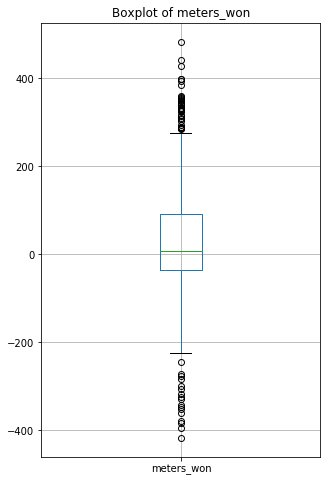

In [86]:
# df_boats_won['meters_won'].boxplot()

df_boats_won.boxplot(column='meters_won', return_type='axes', figsize=(5,8));
plt.title('Boxplot of meters_won')
plt.savefig('boxplot.jpg')

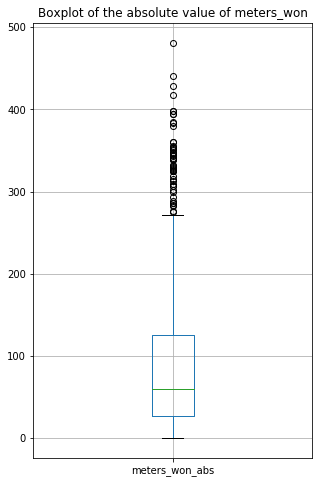

In [87]:
# df_boats_won['meters_won'].boxplot()
df_boats_won['meters_won_abs']=abs(df_boats_won['meters_won'])
df_boats_won.boxplot(column='meters_won_abs', return_type='axes', figsize=(5,8));
plt.title('Boxplot of the absolute value of meters_won')
plt.savefig('boxplot_abs.jpg')

In [88]:
df_boats_won.describe()

,TRK_RACE_NUM_unk,position_at_current_gate,has_taken_biased_gate,leg_after_gate,TRK_LEG_NUM_unk,meters_won,boats_won_on_leg_after_gate,meters_won_abs
count,6.770000e+02,647.000000,677.000000,677.000000,677.000000,669.000000,669.000000,669.000000
mean,2.208517e+07,4.865533,0.512555,3.939439,2.939439,29.399103,0.023916,92.269058
std,1.633738e+04,2.532544,0.500212,0.803576,0.803576,129.135637,1.104981,94.948880
min,2.206180e+07,1.000000,0.000000,3.000000,2.000000,-417.000000,-7.000000,0.000000
25%,2.207300e+07,3.000000,0.000000,3.000000,2.000000,-37.000000,0.000000,27.000000
50%,2.209100e+07,5.000000,1.000000,4.000000,3.000000,6.000000,0.000000,60.000000
75%,2.209240e+07,7.000000,1.000000,5.000000,4.000000,90.000000,0.000000,126.000000
max,2.211130e+07,9.000000,1.000000,5.000000,4.000000,481.000000,5.000000,481.000000


## 6.1SubConclusion
> 
>Looking at the dataframe df_boats_won, we can see that there is 219 times throughout the season, where one boat has either won or lost another (or more) boats on one leg. Hence there are many opportunities to win or loose around the course. Taking the gate bias has ment a gain/loss from -417 meters to +481 meters. Hence there is much to gain, and even though it might not be visable here at the data, getting 350 meters by choosing the correct gatemark should be very beneficial. 
>
>The only clear thing we can see is that there might be a **small** correlation in df_boats_won.corr() between your position and how many boats you gain/looses. The correlation is positive, meaning the more you are behind, the more you might be able to gain. SURPRISE! 
>
>Looking at the number of boats won on next leg, we see no clear tendency that a gate bias has to be a certain amount of meeters before it is beneficial. Acctually we can see, that a boat can easily win the same or more amount of boats when they choose the unbiased gate mark.

# 7 ANOVA test

In [89]:
import scipy.stats as stats
from scipy.stats import ttest_ind

In [90]:
df_boats_won.loc[df_boats_won['boats_won_on_leg_after_gate']>=1]

,TRK_RACE_NUM_unk,BOAT,position_at_current_gate,has_taken_biased_gate,leg_after_gate,TRK_LEG_NUM_unk,meters_won,boats_won_on_leg_after_gate,meters_won_abs
4,22061801.0,CAN,6.0,0.0,4.0,3.0,-102.0,2.0,102.0
6,22061801.0,SUI,7.0,1.0,3.0,2.0,82.0,2.0,82.0
10,22061801.0,AUS,7.0,0.0,4.0,3.0,-102.0,1.0,102.0
15,22061801.0,USA,9.0,0.0,3.0,2.0,-141.0,1.0,141.0
19,22061801.0,FRA,9.0,1.0,4.0,3.0,87.0,1.0,87.0
22,22061801.0,DEN,4.0,1.0,4.0,3.0,86.0,1.0,86.0
27,22061802.0,GBR,4.0,0.0,3.0,2.0,-62.0,1.0,62.0
36,22061802.0,AUS,3.0,0.0,3.0,2.0,-8.0,1.0,8.0
49,22061802.0,DEN,5.0,1.0,4.0,3.0,28.0,1.0,28.0
52,22061802.0,NZL,6.0,1.0,4.0,3.0,30.0,1.0,30.0


In [91]:
aa=df_boats_won[['BOAT','meters_won','boats_won_on_leg_after_gate']].dropna()

In [92]:
df_boats_won = df_boats_won.dropna()

In [93]:
aa=aa.loc[aa['BOAT'].isin(['AUS','SUI'])]

### t-test: 
> Testing whether there is a difference between AUS (the leading boat) and SUi (the last boat) and how often they take the biased gate mark. 

In [94]:
group1= aa.loc[aa['BOAT']=='AUS']['meters_won']
group2= aa.loc[aa['BOAT']=='SUI']['meters_won']

#perform independent two sample t-test
ttest_ind(group1, group2)



Ttest_indResult(statistic=0.7385065643916122, pvalue=0.4614086187937444)

> Since p>0.5 we can not accept the hypothesis that there is a difference. 
>
>Now lets perform an ANOVA and test same hypothesis for all boats

In [95]:

# #define samples
AUS = df_boats_won[df_boats_won['BOAT']=='AUS']['meters_won']
CAN = df_boats_won[df_boats_won['BOAT']=='CAN']['meters_won']
DEN = df_boats_won[df_boats_won['BOAT']=='DEN']['meters_won']
ESP = df_boats_won[df_boats_won['BOAT']=='ESP']['meters_won']
FRA = df_boats_won[df_boats_won['BOAT']=='FRA']['meters_won']
GBR = df_boats_won[df_boats_won['BOAT']=='GBR']['meters_won']
NZL = df_boats_won[df_boats_won['BOAT']=='NZL']['meters_won']
SUI = df_boats_won[df_boats_won['BOAT']=='SUI']['meters_won']
USA = df_boats_won[df_boats_won['BOAT']=='USA']['meters_won']

# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(AUS,CAN,DEN,FRA,ESP,GBR,NZL,SUI,USA)

In [96]:
print(fvalue, pvalue)

0.8118632803347335 0.5922553839282374


> Again, since p>0.5 we can not accept the hypothesis that there is a difference. 

In [97]:
df_boats_won.loc[df_boats_won['boats_won_on_leg_after_gate']>=1].corr()

,TRK_RACE_NUM_unk,position_at_current_gate,has_taken_biased_gate,leg_after_gate,TRK_LEG_NUM_unk,meters_won,boats_won_on_leg_after_gate,meters_won_abs
TRK_RACE_NUM_unk,1.000000,0.019879,-0.045883,-0.032161,-0.032161,-0.028725,-0.007355,0.069165
position_at_current_gate,0.019879,1.000000,0.011877,-0.048753,-0.048753,-0.059388,0.216855,-0.021186
has_taken_biased_gate,-0.045883,0.011877,1.000000,-0.134768,-0.134768,0.714021,0.039623,0.093645
leg_after_gate,-0.032161,-0.048753,-0.134768,1.000000,1.000000,-0.044379,-0.088312,-0.320674
TRK_LEG_NUM_unk,-0.032161,-0.048753,-0.134768,1.000000,1.000000,-0.044379,-0.088312,-0.320674
meters_won,-0.028725,-0.059388,0.714021,-0.044379,-0.044379,1.000000,0.025438,0.028179
boats_won_on_leg_after_gate,-0.007355,0.216855,0.039623,-0.088312,-0.088312,0.025438,1.000000,-0.061668
meters_won_abs,0.069165,-0.021186,0.093645,-0.320674,-0.320674,0.028179,-0.061668,1.000000


>Looking at the correlation table, we also see thatt there are no correlations on the variables. 

# 8 Splitting with the fleet
>
>A **split** is defined as when a boat chooses the opposite mark than the fleet. Often there is a "favoured" mark as in a mark that most boats chooses, mostly because you can save a manouvre because you choose this mark OR because this will lead you to the favoured site of the course. However, from experience as a sailor, I believe that choosing the other mark, just for the sake of a split is often beneficial. But is this a correct hypothesis and how often and by how much? 
>
> How to define a split? Currently a split is WHEN two boats takes the other mark than everyone ells. (30%)

In [98]:
#Start by merging number of boats won on df_merged1
df_merged2 = pd.merge(df_merged1,df_boats_won[['TRK_RACE_NUM_unk','TRK_LEG_NUM_unk','BOAT','boats_won_on_leg_after_gate']],on=['TRK_RACE_NUM_unk','TRK_LEG_NUM_unk','BOAT'], how='left')

In [99]:
df_merged2.to_csv('df_merged2.csv',index =False)

>The next cell creates a dataframe h that is small and just tell what mark a boat has chosen and the boats it has won. 

In [100]:
df_merged2.head()

,BOAT,DATETIME,Latitude,Longitude,BSP_kmh,TWS_kmh,TWD,TWD_TM_deg,TWA,TRK_RACE_NUM_unk,TRK_LEG_NUM_unk,PC_TTB_s,PC_TTK_s,TTS_s,extra,unk_race_ID,POSITION_AT_LAST_MARK*,DELTA,date_column,WW_gate_vectors_first,WW_gate_vectors_second,LW_gate_vectors_first,LW_gate_vectors_second,WG1_long,WG1_lat,WG2_long,WG2_lat,LG1_long,LG1_lat,LG2_long,LG2_lat,Place,dist_betwen_LW_marks,dist_betwen_WW_marks,u_wind_vectorTWD,v_wind_vectorTWD,rel_wind_angle_LWgateTWD,rel_wind_angle_WWgateTWD,avg_leg_TWA,avg_leg_TWA_next_leg,mtr_gain_by_LG1TWD,mtr_gain_by_WG2TWD,median_TWD,u_wind_vectormedian_TWD,v_wind_vectormedian_TWD,rel_wind_angle_LWgatemedian_TWD,rel_wind_angle_WWgatemedian_TWD,mtr_gain_by_LWG1median_TWD,mtr_gain_by_WWG2median_TWD,boat_to_LG1,boat_to_WG1,boat_to_LG2,boat_to_WG2,take_LWG1,take_LWG2,take_WWG1,take_WWG2,dist_to_mark_after_rounding,meters_won,take_biased_gate,boats_won_on_leg_after_gate
0,GBR,2022-06-18 19:12:01,41.888381,-87.590905,15.72,28.88,344.71,340.19,-147.26,22061801.0,0.0,146.06,102.95,119.40,1.0,2022-06-18 19:12:01,NaN,-77.0,2022-06-18,-7.44,0.024,-21.825,-0.9,-87.594043,41.891106,-87.595903,41.891112,-87.593217,41.876205,-87.595642,41.876105,chicago,270.9,207.7,7.615792,-27.857748,102.9,105.5,NaN,NaN,0.0,0.0,352.340,3.849540,-28.622289,95.3,97.8,0.0,0.0,264.5,350.7,532.2,558.4,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN
1,CAN,2022-06-18 19:12:01,41.888182,-87.592916,61.08,25.33,0.40,357.96,-73.31,22061801.0,0.0,65.12,116.65,119.50,1.0,2022-06-18 19:12:01,NaN,-3.0,2022-06-18,-7.44,0.024,-21.825,-0.9,-87.594043,41.891106,-87.595903,41.891112,-87.593217,41.876205,-87.595642,41.876105,chicago,270.9,207.7,-0.176835,-25.329383,87.2,89.8,NaN,NaN,0.0,0.0,352.200,3.437675,-25.095643,95.4,98.0,0.0,0.0,65.5,126.7,309.7,333.9,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN
2,SUI,2022-06-18 19:12:01,41.887851,-87.593025,34.13,23.18,2.67,357.32,-52.18,22061801.0,0.0,89.70,115.65,119.50,1.0,2022-06-18 19:12:01,NaN,-9.0,2022-06-18,-7.44,0.024,-21.825,-0.9,-87.594043,41.891106,-87.595903,41.891112,-87.593217,41.876205,-87.595642,41.876105,chicago,270.9,207.7,-1.079804,-23.154836,85.0,87.5,NaN,NaN,0.0,0.0,351.565,3.400212,-22.929260,96.1,98.6,0.0,0.0,58.7,114.7,297.4,321.8,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN
3,AUS,2022-06-18 19:12:01,41.886923,-87.596583,19.70,22.68,358.01,356.70,-40.47,22061801.0,0.0,119.72,98.65,118.60,1.0,2022-06-18 19:12:01,NaN,-15.0,2022-06-18,-7.44,0.024,-21.825,-0.9,-87.594043,41.891106,-87.595903,41.891112,-87.593217,41.876205,-87.595642,41.876105,chicago,270.9,207.7,0.787565,-22.666322,89.6,92.2,NaN,NaN,0.0,0.0,352.250,3.058419,-22.472839,95.4,97.9,0.0,0.0,379.4,284.4,116.7,78.5,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN
4,ESP,2022-06-18 19:12:01,41.883369,-87.597178,21.51,23.96,356.86,6.35,-31.50,22061801.0,0.0,295.43,58.15,118.65,1.0,2022-06-18 19:12:01,NaN,-5.0,2022-06-18,-7.44,0.024,-21.825,-0.9,-87.594043,41.891106,-87.595903,41.891112,-87.593217,41.876205,-87.595642,41.876105,chicago,270.9,207.7,1.312431,-23.924028,90.8,93.3,NaN,NaN,0.0,0.0,353.730,2.616764,-23.816678,93.9,96.5,0.0,0.0,443.7,352.1,174.9,147.0,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN


In [101]:
#Boats gained on next leg 
# ALso make a column that says how many meters was gained on takin the biased mark
def boats_gained_on_next_leg(data):
    race_number = list(data['TRK_RACE_NUM_unk'].unique())
    leg_number = list(data['TRK_LEG_NUM_unk'].unique())
    boat_number = list(data['BOAT'].unique())
    df_chosen_gatemark = pd.DataFrame()
    

    for raceid in range(len(race_number)):
        for legid in range(len(leg_number)):
            for boatid in range(len(boat_number)):
                a= data.loc[data['BOAT']==boat_number[boatid]]
                b= a.loc[a['TRK_RACE_NUM_unk']==race_number[raceid]]
                c= b.loc[b['TRK_LEG_NUM_unk']==leg_number[legid]]
                for row in range(len(c)):
                    if c[['take_LWG1','take_LWG2','take_WWG1','take_WWG2']].iloc[row].sum() == 1:
                        df_chosen_gatemark=df_chosen_gatemark.append(c[['TRK_RACE_NUM_unk','TRK_LEG_NUM_unk','BOAT','take_LWG1','take_LWG2','take_WWG1','take_WWG2','boats_won_on_leg_after_gate','meters_won','take_biased_gate']].iloc[row])
#                         print(df_chosen_gatemark)
                        break
    return(df_chosen_gatemark)
                        

In [102]:
h= boats_gained_on_next_leg(df_merged2)

>We need to look at whether the boats take a split: The following creates a dataframe df2 that takes all legs where there has been a split (e.g. a min. 1 boat and max. 2 boats takes the other mark. 

In [103]:

take_the_split = []
take_the_split2 = []
boats_wonn = []
df2 = pd.DataFrame()
for raceid in range(len(race_number)):
#     print(race_number[raceid])
    for legid in range(len(leg_number)):
#         print(race_number[raceid], legid)
        d= h.loc[h['TRK_RACE_NUM_unk']==race_number[raceid]]
        e = d.loc[d['TRK_LEG_NUM_unk']==leg_number[legid]]
#         print(e)
#Is there a split at LG1?
        if (e['take_LWG1'].sum() < (e['take_LWG2'].sum()*0.4)) & (e['take_LWG1'].sum() >= 1):
            df2 = df2.append(e)
#             print('heJ')
# IS there a split at LG2? 
        elif (e['take_LWG2'].sum() < (e['take_LWG1'].sum()*0.4)) & (e['take_LWG2'].sum() >= 1):
            df2 = df2.append(e)
#Is there a split at WWG1? 
        elif (e['take_WWG1'].sum() < (e['take_WWG2'].sum()*0.4) ) & (e['take_WWG1'].sum() >= 1):
            df2 = df2.append(e)   
#Is there a split at WWG2? 
        elif (e['take_WWG2'].sum() < (e['take_WWG1'].sum()*0.4)) & (e['take_WWG2'].sum() >= 1):
            df2 = df2.append(e)
         
            
df2=df2.reset_index(drop=True)

>And here we crete a dataframe where the column "take_split" is inserted 

In [104]:

take_the_split = []
take_the_split2 = []
boats_wonn = []
df1 = pd.DataFrame()
for raceid in range(len(race_number)):
#     print(race_number[raceid])
    for legid in range(len(leg_number)):
#         print(race_number[raceid], legid)
        d= h.loc[h['TRK_RACE_NUM_unk']==race_number[raceid]]
        e = d.loc[d['TRK_LEG_NUM_unk']==leg_number[legid]]
#         print(e)
#Is there a split at LG1?
        if (e['take_LWG1'].sum() < (e['take_LWG2'].sum()*0.4)) & (e['take_LWG1'].sum() >= 1):
            df1 = df1.append(e['take_LWG1'].reset_index(drop=True).to_frame())

# IS there a split at LG2? 
        elif (e['take_LWG2'].sum() < (e['take_LWG1'].sum()*0.4)) & (e['take_LWG2'].sum() >= 1):
            df1 = df1.append(e['take_LWG2'].reset_index(drop=True).to_frame())
#Is there a split at WWG1? 
        elif (e['take_WWG1'].sum() < (e['take_WWG2'].sum()*0.4) ) & (e['take_WWG1'].sum() >= 1):
            df1 = df1.append(e['take_WWG1'].reset_index(drop=True).to_frame())
#Is there a split at WWG2? 
        elif (e['take_WWG2'].sum() < (e['take_WWG1'].sum()*0.4)) & (e['take_WWG2'].sum() >= 1):
            df1 = df1.append(e['take_WWG2'].reset_index(drop=True).to_frame())
    
  
            
            
df1=df1.reset_index(drop=True)

take_split = []           
for row in range(len(df1)):
#     print(df1.iloc[row].sum())
    if df1.iloc[row].sum() == 1:
        take_split.append(1)
    else: 
        take_split.append(0)
        
df1['take_split'] = take_split
df1 = df1.reset_index(drop=True)

>Lastly we join the "take_split" column with df2

In [105]:
extracted_col = df1['take_split']
print("column to added from first dataframe to second:")
# display(extracted_col)
  
df2 = df2.join(extracted_col)
print("Second dataframe after adding column from first dataframe:")

column to added from first dataframe to second:
Second dataframe after adding column from first dataframe:


In [106]:
df2.corr()

,TRK_RACE_NUM_unk,TRK_LEG_NUM_unk,take_LWG1,take_LWG2,take_WWG1,take_WWG2,boats_won_on_leg_after_gate,meters_won,take_biased_gate,take_split
TRK_RACE_NUM_unk,1.000000,0.102447,-0.070821,0.077300,-0.005223,-0.010012,0.003213,0.043444,0.018868,-0.032990
TRK_LEG_NUM_unk,0.102447,1.000000,0.160956,-0.233330,0.052692,0.074129,-0.015943,0.085338,-0.054298,0.000482
take_LWG1,-0.070821,0.160956,1.000000,-0.641389,-0.205844,-0.289589,-0.053745,-0.088203,-0.197861,0.067407
take_LWG2,0.077300,-0.233330,-0.641389,1.000000,-0.256286,-0.360553,0.058444,0.226707,0.369470,-0.095892
take_WWG1,-0.005223,0.052692,-0.205844,-0.256286,1.000000,-0.115714,-0.042052,-0.129340,-0.144664,0.184548
take_WWG2,-0.010012,0.074129,-0.289589,-0.360553,-0.115714,1.000000,0.021788,-0.105430,-0.148445,-0.095656
boats_won_on_leg_after_gate,0.003213,-0.015943,-0.053745,0.058444,-0.042052,0.021788,1.000000,0.075606,0.102645,0.087520
meters_won,0.043444,0.085338,-0.088203,0.226707,-0.129340,-0.105430,0.075606,1.000000,0.722139,-0.402800
take_biased_gate,0.018868,-0.054298,-0.197861,0.369470,-0.144664,-0.148445,0.102645,0.722139,1.000000,-0.355658
take_split,-0.032990,0.000482,0.067407,-0.095892,0.184548,-0.095656,0.087520,-0.402800,-0.355658,1.000000


>Let us look at the boats taking a split. How many boats are lost and won in total? 

In [107]:
df2.loc[df2['take_split']==1]['boats_won_on_leg_after_gate'].mean()

0.25

In [108]:
df2.loc[df2['take_split']==0]['boats_won_on_leg_after_gate'].mean()

-0.029411764705882353

>What about how many boats are won, only looking at the sum of boats won: 

In [109]:
df2.loc[df2['take_split']==1]['boats_won_on_leg_after_gate'].sum()


11.0

In [110]:
df2.loc[df2['take_split']==1].loc[df2['boats_won_on_leg_after_gate']>0]#.sum()


,TRK_RACE_NUM_unk,TRK_LEG_NUM_unk,BOAT,take_LWG1,take_LWG2,take_WWG1,take_WWG2,boats_won_on_leg_after_gate,meters_won,take_biased_gate,take_split
5,22061801.0,2.0,USA,1.0,0.0,0.0,0.0,1.0,-141.0,0.0,1
43,22073001.0,3.0,ESP,0.0,0.0,1.0,0.0,2.0,121.0,1.0,1
61,22073002.0,3.0,USA,0.0,0.0,1.0,0.0,1.0,-272.0,0.0,1
103,22082003.0,2.0,NZL,1.0,0.0,0.0,0.0,2.0,4.0,1.0,1
109,22091001.0,3.0,USA,0.0,0.0,0.0,1.0,2.0,1.0,1.0,1
110,22091001.0,3.0,FRA,0.0,0.0,0.0,1.0,4.0,-5.0,0.0,1
132,22091003.0,2.0,AUS,0.0,1.0,0.0,0.0,3.0,150.0,1.0,1
134,22091003.0,2.0,FRA,0.0,1.0,0.0,0.0,4.0,120.0,1.0,1
157,22092402.0,3.0,SUI,0.0,0.0,1.0,0.0,1.0,2.0,1.0,1
217,22111304.0,2.0,SUI,1.0,0.0,0.0,0.0,1.0,-120.0,0.0,1


In [111]:
df2['take_split'].sum()

44

>Ther is 44 times where a boat takes a split!  11 times where the split leads to boats won and 8 times where it leads to a loss. 

## 8.1 Subcnclussion 
> 
>A split with the fleet does meen more gained/losed boats. We see that the summation of boats won vs. lost is 2, hence there are slightly more won boats. However, it is not much, and there are no clear tendency. 

# Conclusion 
>
>From the above data analysis, we have not found any clear tendency when it comes to gatebias. This is of great disappointment, since I though that we would see some kind of tendency. 
>
>However, if we look at the concrete findings we have: 
>
> * **TWD** is never TRUE. It is difficult to find ONE TWD because of several reasons: 
>> * 1) Each boat has there own TWD. This TWD is influenced by boat speed, manouvre (turn rate), wheter or not a boat has clear air (or another boat is covering that boat), and most likely, calibration. Hence TWD can easilty vary >30 degrees on one leg. 
>> * 2) Finding a TWD early enough on the leg is difficult. Since the TWD varies every single second, having an avg. TWD for one leg is impossible. Even when getting closer to the gate, it is not stable enough to really count on the TWD. 
>>> **We can learn that when sailing, I need to be very careful on looking at the numbers on the wing screen for TWD. Use eyes much more.** 
>
> * The distribution of taking the biased vs unbised mark is almost 50/50. This means that ther might be something to gain if you are nore determined on taking the biased gate mark compared to the fleet! 
> * Boats more often choose the LW gate bias than the WW gate bias
> * Boats that is rounding LW biased gate mark loose more than they win boats.
> * You win more by choosing WW gate bias and loose more by choosing LW gate bias

> * Looking at the dataframe df_boats_won, we can see that there is 259 times throughout the season, where one boat has either won or lost another (or more) boats on one leg. Hence there are many opportunities to win or loose around the course. Taking the gate bias has ment a gain/loss from -276 meters to +352 meters (when taking max and min from df_merged1). Hence there is much to gain, and even though it might not be visable here at the data, getting 350 meters by choosing the correct gatemark should be very beneficial. 
>
> * When looking at a split, again we see no clear tendency. More boats are won/lost in a split, but it is not possible to say whether it is beneficial. 


